# World Data League 2022

## 🎯 Challenge
*Optimization of public transport routes during road interruptions*


## 👥 Authors
* Natascia Caria
* Claudia Cozzolino
* Alfredo Petrella

## 💻 Development

Effective and reliable public transportations are the foundation of modern urban systems and sustainable mobility promotion. The Bayesciamella team decided to propose a tool for real-time Cascais bus trip reorganization in case of road maintenances and disruptions.

### Install and load requirements

In [ ]:
!pip install geopandas osmnx

In [ ]:
!pip install -U googlemaps

In [3]:
#################
# Load libraries
#################
import os
import sys
import json
import pickle
import logging

import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

import folium
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, LineString

import networkx as nx

# Google services
import googlemaps
from google.colab import drive

In [4]:
# Logging config
logging.basicConfig(
    format='%(asctime)s | %(levelname)s : %(message)s',
    level=logging.INFO, stream=sys.stdout
)

In [ ]:
################
# Working paths
################
mainPath = '/content/gdrive/MyDrive/WorldDataLeague/Stage2/\
Optimization_of_public_transport_routes_during_road_interruptions'

# Point Colaboratory to My Drive
drive.mount('/content/gdrive/')
os.chdir(mainPath)

# Data folder
dataPath = os.path.join(mainPath, "data")
if not os.path.exists(dataPath):
  # Create directory
  os.makedirs(dataPath)
  logging.info(f"Directory created at: {dataPath}")

logging.info(f"Working directory: {os.getcwd()}")

First, we let the data speak for themself by thoroughly exploring the various databases provided by the Cascais municipality.
To have a better understanding of the organization of urban mobility we exploited Geopandas and Google Maps Geocoding API to graphically display on a map the bus routes, the bus stops and the maintenance interventions density.

### GTFS Public Transport Network of Cascais

The General Transit Feed Specification (GTFS) defines a common format for public transportation schedules and associated geographic information.

#### Data request

[link](https://dadosabertos.cascais.pt/dataset/gtfs-mobicascais)



```
!gdown --id 13ucYiAJRtu-gXsLa02qKJrGOgDjbnUWX \
    -O data/gtfs_public_transport_network_of_cascais.zip && \
    unzip data/gtfs_public_transport_network_of_cascais.zip \
    -d data/gtfs_public_transport_network_of_cascais
```



#### Data description

Sources:


*  [Google](https://developers.google.com/transit/gtfs/reference/#dataset_files)

*  [Cascais dictionary](https://docs.google.com/spreadsheets/d/10IUS4sdJPEgGHunAlUyG50ww2Kntt69MFSnePL5h-BU/edit#gid=850019181)



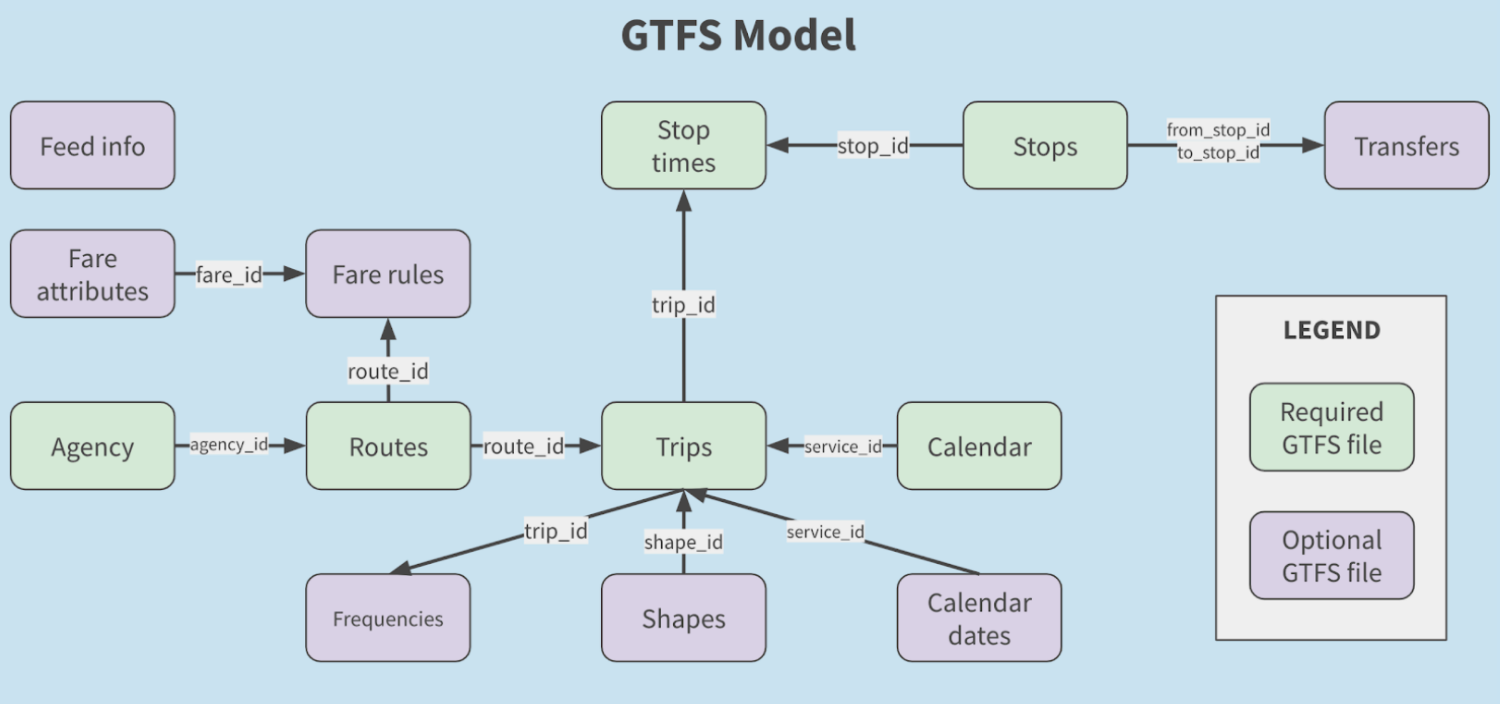

| **Filename** | **Required** | **Defines** | Number of rows | Granularity |
|---|---|---|---|---|
| agency.txt | Required | Transit agencies with service represented in this dataset. | 1 | One row per agency. |
| stops.txt | Required | Stops where vehicles pick up or drop off riders. Also defines stations and station entrances. | 1043 | One row per stop. |
| routes.txt | Required | Transit routes. A route is a group of trips that are displayed to riders as a single service. | 44 | One row per route. |
| trips.txt | Required | Trips for each route. A trip is a sequence of two or more stops that occur during a specific time period. | 3644 | One row per trip. |
| stop_times.txt | Required | Times that a vehicle arrives at and departs from stops for each trip. | 111768 | One row per stop on a trip. |
| calendar.txt | Conditionally required | Service dates specified using a weekly schedule with start and end dates. | 6 | One row per service. |
| calendar_dates.txt | Conditionally required | Exceptions for the services defined in the calendar.txt. | 299 | One row per exception. |
| fare_attributes.txt | Optional | Fare information for a transit agency's routes. | 2 | One row per fare class. |
| shapes.txt | Optional | Rules for mapping vehicle travel paths, sometimes referred to as route alignments. | 46780 | One row per shape point. |
| feed_info.txt | Conditionally required | Dataset metadata, including publisher, version, and expiration information. | 1 | One row per organization. |

As not all datasets have been used in this context, we analyse here those most relevant for understanding the problem. Please refer to the appendix to see the other available datasets.

#### EDA

In [6]:
gtfs_dataPath = os.path.join(
    mainPath, "data", "gtfs_public_transport_network_of_cascais"
)

##### Stops

Stops where vehicles pick up or drop off riders. Also defines stations and station entrances.

[stops field definitions](https://developers.google.com/transit/gtfs/reference/#stopstxt)

In [7]:
df_stops = pd.read_csv(os.path.join(gtfs_dataPath, "stops.txt"))

# Drop columns with all NaN values
df_stops = df_stops.dropna(how='all', axis=1)

df_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   stop_id         1043 non-null   int64  
 1   stop_name       1043 non-null   object 
 2   stop_lat        1043 non-null   float64
 3   stop_lon        1043 non-null   float64
 4   location_type   12 non-null     float64
 5   parent_station  10 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 49.0+ KB


In [8]:
# Dataset view
df_stops.head(10)

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
0,155956,Rua do Alcaide,38.708218,-9.418101,NaN,NaN
1,155879,Rua do Alcaide,38.708844,-9.417902,NaN,NaN
2,5066,Rua Depósitos da Água,38.717552,-9.435612,NaN,NaN
3,5064,Cascais Estação - Av. D. Pedro I,38.701807,-9.418965,NaN,NaN
4,5067,Rua Depósitos da Água,38.717564,-9.435739,NaN,NaN
5,5063,Matarraque,38.707864,-9.354278,NaN,NaN
6,5664,Atibá,38.720911,-9.377369,NaN,NaN
7,156361,Tires,38.712995,-9.351251,NaN,NaN
8,7613,Hipódromo,38.694098,-9.426844,NaN,NaN
9,7618,Largo Rossio Pequeno,38.738260,-9.339752,NaN,NaN


Looking at the number of unique values per columns, we see that:

* the stops are uniquely identified by the stop id, as expected;

* the stop name, on the other hand, does not uniquely identify a stop.

In [9]:
# Number of unique values per column
df_stops.nunique(dropna=False)

stop_id           1043
stop_name          570
stop_lat          1027
stop_lon          1034
location_type        3
parent_station       3
dtype: int64

This means that, in general, there may be several stops with the same stop name:

In [10]:
# Count number of stops per stop name
df_stops.groupby("stop_name").size().to_frame("num_stops").sort_values(
    by="num_stops",
    ascending=False
)

,num_stops
stop_name,
Matarraque,5
Fonte da Carreira,4
Praceta Francisca Lindoso,4
Rotunda - Rua Conde Barão,4
Pai do Vento,4
...,...
Carcavelos - Estação - Cais 4,1
Carcavelos - Estação - Cais 3,1
Carcavelos - Estação - Cais 2,1


Let us now check that the coordinates pairs (latitude, longitude) are unique per stop as the stop id is:

In [11]:
# Count number of stops per stop (lat, lon) pair
df_stops.groupby(["stop_lat", "stop_lon"]).size().to_frame("num_stops"
).sort_values(by="num_stops", ascending=False)

,,num_stops
stop_lat,stop_lon,
38.679561,-9.325649,1
38.719767,-9.406748,1
38.719820,-9.418574,1
38.719832,-9.406900,1
38.719869,-9.418911,1
...,...,...
38.706556,-9.373275,1
38.706564,-9.384959,1
38.706573,-9.429054,1


Most of the location types in the data are NaN, only a few are 0 or 1:

In [12]:
# Unique pairs of location type and parent station
df_stops.groupby(["location_type", "parent_station"], dropna=False).size()

location_type  parent_station
0.0            155664.0             5
               157295.0             5
1.0            NaN                  2
NaN            NaN               1031
dtype: int64

**Note on location types**

Type of the location:
* 0 (or empty): Stop (or Platform). A location where passengers board or disembark from a transit vehicle. Is called a platform when defined within a parent_station.
* 1: Station. A physical structure or area that contains one or more platform.

By combining the latitude and longitude columns, we can obtain the positions of the stops as points in space and load the data using the GeoPandas library, which we will use later to help us visualise the data.

In [13]:
# To Geo data
stops_geometry = [
    Point(xy) for xy in zip(df_stops.stop_lon, df_stops.stop_lat)
]
geo_stops = gpd.GeoDataFrame(df_stops, geometry=stops_geometry)

In [14]:
geo_stops.head(5)

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station,geometry
0,155956,Rua do Alcaide,38.708218,-9.418101,NaN,NaN,POINT (-9.41810 38.70822)
1,155879,Rua do Alcaide,38.708844,-9.417902,NaN,NaN,POINT (-9.41790 38.70884)
2,5066,Rua Depósitos da Água,38.717552,-9.435612,NaN,NaN,POINT (-9.43561 38.71755)
3,5064,Cascais Estação - Av. D. Pedro I,38.701807,-9.418965,NaN,NaN,POINT (-9.41897 38.70181)
4,5067,Rua Depósitos da Água,38.717564,-9.435739,NaN,NaN,POINT (-9.43574 38.71756)


##### Routes

Transit routes. A route is a group of trips that are displayed to riders as a single service

[Routes field definitions](https://developers.google.com/transit/gtfs/reference/#routestxt)

In [15]:
# Routes
df_routes = pd.read_csv(os.path.join(gtfs_dataPath, "routes.txt"))

# Drop columns with all NaN values
df_routes = df_routes.dropna(how='all', axis=1)

df_routes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   route_id          44 non-null     object
 1   agency_id         44 non-null     object
 2   route_short_name  44 non-null     object
 3   route_long_name   44 non-null     object
 4   route_type        44 non-null     int64 
 5   route_color       44 non-null     object
 6   route_text_color  44 non-null     object
 7   route_sort_order  44 non-null     int64 
dtypes: int64(2), object(6)
memory usage: 2.9+ KB


In [16]:
# Dataset view
df_routes.head(5)

,route_id,agency_id,route_short_name,route_long_name,route_type,route_color,route_text_color,route_sort_order
0,M01,mobi_cascais_bus,M01,Parede Terminal - CascaiShopping via Estoril,3,ce5504,ffffff,1
1,M02,mobi_cascais_bus,M02,Cascais Estação - Malveira (Circular),3,ce5504,ffffff,2
2,M03,mobi_cascais_bus,M03,Torre - CascaiShopping (Circular),3,b10086,ffffff,3
3,M04,mobi_cascais_bus,M04,Cascais Estação - Torre (Circular),3,b10086,ffffff,4
4,M05,mobi_cascais_bus,M05,Cascais Estação - Guincho via Qta. da Marinha ...,3,0d7215,ffffff,5


In [17]:
# Number of unique values per column
df_routes.nunique(dropna=False)

route_id            44
agency_id            1
route_short_name    44
route_long_name     43
route_type           1
route_color         13
route_text_color     1
route_sort_order    44
dtype: int64

##### Trips

Trips for each route. A trip is a sequence of two or more stops that occur during a specific time period.

[Trips field definitions](https://developers.google.com/transit/gtfs/reference/#tripstxt)

In [18]:
# Trips
df_trips = pd.read_csv(os.path.join(gtfs_dataPath, "trips.txt"))

# Drop columns with all NaN values
df_trips = df_trips.dropna(how='all', axis=1)

df_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3644 entries, 0 to 3643
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   route_id       3644 non-null   object
 1   service_id     3644 non-null   object
 2   trip_id        3644 non-null   object
 3   trip_headsign  811 non-null    object
 4   direction_id   3644 non-null   int64 
 5   shape_id       3644 non-null   object
dtypes: int64(1), object(5)
memory usage: 170.9+ KB


In [19]:
# Dataset view
df_trips.head(5)

,route_id,service_id,trip_id,trip_headsign,direction_id,shape_id
0,M01,A-SDF,M01-2-032-A-SDF-19h00-CascaiShopping,Parede Terminal,1,ubyl
1,M01,A-SDF,M01-2-038-A-SDF-24h15-CascaiShopping,Parede Terminal,1,ubyl
2,M01,A-U,M01-1-009-A-U-15h15-ParedeTerminalR,NaN,0,p9c8
3,M01,A-U,M01-1-010-A-U-16h00-ParedeTerminalR,NaN,0,p9c8
4,M01,A-U,M01-1-011-A-U-16h45-ParedeTerminalR,NaN,0,p9c8


In [20]:
# Number of unique values per column
df_trips.nunique(dropna=False)

route_id           44
service_id          6
trip_id          3644
trip_headsign      10
direction_id        2
shape_id          131
dtype: int64

The trips, uniquely identified by trip_id, are 3644. However we see that there are a total of only 131 unique shapes associated with them. In fact, the trips may refer to the same shape travelled by a bus at different times or days.

In [21]:
# Top 5 shape per number of trips associated
df_trips.groupby(["shape_id"]).size().to_frame("num_trips").sort_values(
    by="num_trips",
    ascending=False
).head(5)

,num_trips
shape_id,
sjr4,107
448f,104
1lkp,104
2fn9,92
fgug,92


While the direction is unique per each shape:

In [22]:
len(df_trips.groupby(["shape_id", "direction_id"])) == df_trips.shape_id.nunique()

True

##### Stop times

Times that a vehicle arrives at and departs from stops for each trip.

[Stop times field descriptions](https://developers.google.com/transit/gtfs/reference/#stop_timestxt)

In [23]:
# Stop times
df_stop_times = pd.read_csv(os.path.join(gtfs_dataPath, "stop_times.txt"))

# Drop columns with all NaN values
df_stop_times = df_stop_times.dropna(how='all', axis=1)

df_stop_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111768 entries, 0 to 111767
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              111768 non-null  object 
 1   arrival_time         111768 non-null  object 
 2   departure_time       111768 non-null  object 
 3   stop_id              111768 non-null  int64  
 4   stop_sequence        111768 non-null  int64  
 5   shape_dist_traveled  111768 non-null  float64
 6   timepoint            111768 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 6.0+ MB


In [24]:
# Dataset view
df_stop_times.head(5)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,shape_dist_traveled,timepoint
0,M01-1-001-A-U-09h15-ParedeTerminalR,09:15:00,09:15:00,200037,1,0.00,1
1,M01-1-001-A-U-09h15-ParedeTerminalR,09:17:00,09:17:00,155665,2,667.36,0
2,M01-1-001-A-U-09h15-ParedeTerminalR,09:18:00,09:18:00,155666,3,1031.42,0
3,M01-1-001-A-U-09h15-ParedeTerminalR,09:20:00,09:20:00,155667,4,1507.10,0
4,M01-1-001-A-U-09h15-ParedeTerminalR,09:21:30,09:21:30,155668,5,1943.08,1


In [25]:
# Number of unique values per column
df_stop_times.nunique(dropna=False) 

trip_id                 3644
arrival_time           44090
departure_time         44090
stop_id                 1041
stop_sequence             89
shape_dist_traveled     3624
timepoint                  2
dtype: int64

By grouping the stop time data by trip id, we can derive information such as the start and end time of a trip, the stops composing a trip, the number of total stops, the total distance travelled.

In [26]:
# Group data by trip id and aggregate stops information
df_stop_times.groupby("trip_id").agg(
    trip_start = ("arrival_time", lambda x: list(x)[0]),
    trip_end = ("arrival_time", lambda x: list(x)[-1]),
    stop_ids = ("stop_id", lambda x: list(x)),
    num_stops = ('stop_sequence', 'max'),
    tot_dist = ('shape_dist_traveled', 'max')
)

,trip_start,trip_end,stop_ids,num_stops,tot_dist
trip_id,,,,,
M01-1-001-A-U-09h15-ParedeTerminalR,09:15:00,09:55:00,"[200037, 155665, 155666, 155667, 155668, 15566...",19,11800.20
M01-1-002-A-U-10h00-ParedeTerminalR,10:00:00,10:40:00,"[200037, 155665, 155666, 155667, 155668, 15566...",19,11800.20
M01-1-003-A-U-10h45-ParedeTerminalR,10:45:00,11:25:00,"[200037, 155665, 155666, 155667, 155668, 15566...",19,11800.20
M01-1-004-A-U-11h30-ParedeTerminalR,11:30:00,12:10:00,"[200037, 155665, 155666, 155667, 155668, 15566...",19,11800.20
M01-1-005-A-U-12h15-ParedeTerminalR,12:15:00,12:55:00,"[200037, 155665, 155666, 155667, 155668, 15566...",19,11800.20
...,...,...,...,...,...
M44-1-004-A-SDF-12h30-CascaisEstacaoL,12:30:00,13:02:00,"[156385, 155710, 200007, 200009, 200011]",5,12510.68
M44-2-001-A-U-13h15-BarragemdoRioda,13:15:00,13:46:00,"[200011, 200010, 200008, 155858, 156385]",5,12492.19
M44-2-002-A-U-17h10-BarragemdoRioda,17:10:00,17:41:00,"[200011, 200010, 200008, 155858, 156385]",5,12492.19


From data description, we know we can merge df_stop_times and df_stops on the trip id.
We can also merge df_stop_times and df_trips by trip id:

In [27]:
# Merge df_stop_times with df_stops
df_stop_times_stops = pd.merge(
    df_stop_times[
        ["trip_id", "arrival_time", "departure_time", "stop_sequence",
         "shape_dist_traveled", "stop_id"]
    ],
    df_stops[["stop_id", "stop_name", "stop_lat", "stop_lon", "geometry"]],
    on="stop_id"
)

# Merge df_stop_times and df_stops with df_trips
df_stop_times_stops_trips = pd.merge(
    df_stop_times_stops,
    df_trips[["trip_id", "route_id", "service_id", "direction_id", "shape_id"]],
    on="trip_id"
)

In [28]:
df_stop_times_stops_trips.head()

,trip_id,arrival_time,departure_time,stop_sequence,shape_dist_traveled,stop_id,stop_name,stop_lat,stop_lon,geometry,route_id,service_id,direction_id,shape_id
0,M01-1-001-A-U-09h15-ParedeTerminalR,09:15:00,09:15:00,1,0.00,200037,Parede - Terminal - Rua de Timor,38.691912,-9.359075,POINT (-9.35908 38.69191),M01,A-U,0,p9c8
1,M01-1-001-A-U-09h15-ParedeTerminalR,09:17:00,09:17:00,2,667.36,155665,Jardins da Parede,38.695105,-9.363669,POINT (-9.36367 38.69510),M01,A-U,0,p9c8
2,M01-1-001-A-U-09h15-ParedeTerminalR,09:18:00,09:18:00,3,1031.42,155666,Av. Jardim,38.695994,-9.367510,POINT (-9.36751 38.69599),M01,A-U,0,p9c8
3,M01-1-001-A-U-09h15-ParedeTerminalR,09:20:00,09:20:00,4,1507.10,155667,Rua 9 de Abril,38.697274,-9.372574,POINT (-9.37257 38.69727),M01,A-U,0,p9c8
4,M01-1-001-A-U-09h15-ParedeTerminalR,09:21:30,09:21:30,5,1943.08,155668,Areias,38.699385,-9.376229,POINT (-9.37623 38.69938),M01,A-U,0,p9c8


With this information, we can filter the data by route_id, shape_id or trip_id and display the stops as the time progresses.

In [ ]:
# Example filtering data by trip id
df_to_plot = df_stop_times_stops_trips.loc[
    df_stop_times_stops_trips.trip_id.isin(
        [
         "M01-1-001-A-U-09h15-ParedeTerminalR",
         "M01-1-002-A-U-10h00-ParedeTerminalR"
        ]
    )
]

# Animated scatter plot
fig = px.scatter(
    df_to_plot.sort_values(by="arrival_time"), x="stop_lon", y="stop_lat",
    animation_frame="arrival_time", animation_group="trip_id",
    hover_name="trip_id", color="trip_id", size="shape_dist_traveled",
    range_x=[df_to_plot.stop_lon.min(),df_to_plot.stop_lon.max()],
    range_y=[df_to_plot.stop_lat.min(),df_to_plot.stop_lat.max()]
)
fig.update_layout(showlegend=False)

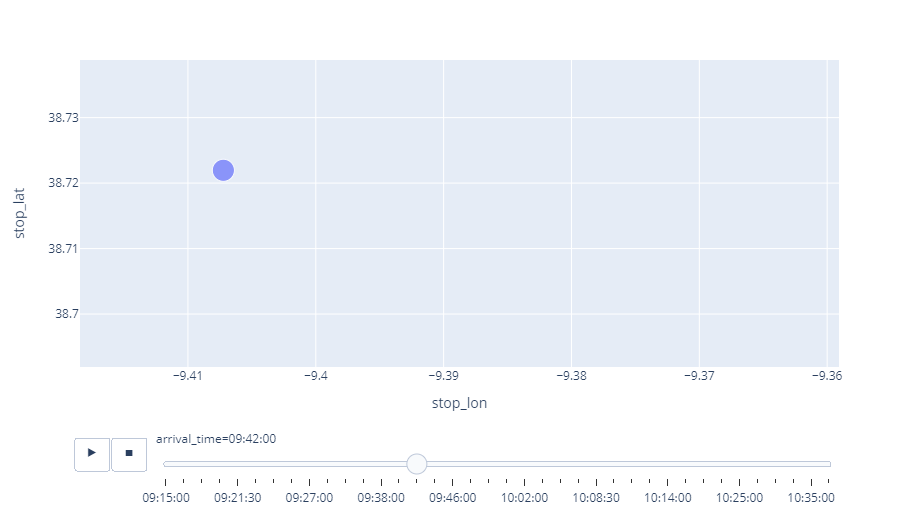

##### Shapes

Rules for mapping vehicle travel paths, sometimes referred to as route alignments.

[Shapes field descriptions](https://developers.google.com/transit/gtfs/reference/#shapestxt)

In [30]:
# Shapes
df_shapes = pd.read_csv(
    os.path.join(gtfs_dataPath, "shapes.txt")
)

In [31]:
# Dataset view
df_shapes.head(5)

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,f6n9,38.70153,-9.42002,0,0.00
1,f6n9,38.70177,-9.41968,1,39.78
2,f6n9,38.70191,-9.41956,2,58.51
3,f6n9,38.70202,-9.41995,3,94.50
4,f6n9,38.70222,-9.42055,4,151.12


In [32]:
# Latitude min and max
print("Minimum latitude:\t", df_shapes.shape_pt_lat.min())
print("Maximum latitude:\t", df_shapes.shape_pt_lat.max())

Minimum latitude:	 38.67976
Maximum latitude:	 38.76361


In [33]:
# Longitude min and max
print("Minimum longitude:\t", df_shapes.shape_pt_lon.min())
print("Maximum longitude:\t", df_shapes.shape_pt_lon.max())

Minimum longitude:	 -9.48491
Maximum longitude:	 -9.31282


In [34]:
# To GeoDataFrame
shapes_geometry = [
    Point(xy) for xy in zip(df_shapes.shape_pt_lon, df_shapes.shape_pt_lat)
]
geo_shapes = gpd.GeoDataFrame(df_shapes, geometry=shapes_geometry)

geo_shapes_by_id = geo_shapes.groupby('shape_id')['geometry'].apply(
    lambda x: LineString(x.tolist())
).reset_index()
geo_shapes_by_id = gpd.GeoDataFrame(geo_shapes_by_id, geometry='geometry')

In [35]:
# Merge shapes geometries with trips ids
df_routes_and_trips_of_a_shape = df_trips.groupby("shape_id").agg(
    routes = ("route_id", lambda x: np.unique(list(x))),
    trips = ("trip_id", lambda x: np.unique(list(x)))
)

geo_shapes_by_id = pd.merge(
    geo_shapes_by_id, df_routes_and_trips_of_a_shape,
    how='inner', on='shape_id'
)

In [36]:
geo_shapes_by_id.sort_values(by="routes").head()

,shape_id,geometry,routes,trips
90,p9c8,"LINESTRING (-9.35911 38.69191, -9.35906 38.692...",M01,"[M01-1-001-A-U-09h15-ParedeTerminalR, M01-1-00..."
114,ubyl,"LINESTRING (-9.40121 38.73885, -9.40122 38.738...",M01,"[M01-2-001-A-U-10h00-CascaiShopping, M01-2-002..."
72,j1rg,"LINESTRING (-9.42001 38.70153, -9.42002 38.701...",M02,"[M02-1-003-A-U-07h05-CascaisTerminal, M02-1-00..."
119,vbc9,"LINESTRING (-9.42001 38.70153, -9.42002 38.701...",M02,M02-1-019-A-U-20h10-CascaisTerminal
23,6j0b,"LINESTRING (-9.44878 38.75171, -9.44846 38.752...",M02,"[M02-1-001-A-U-05h30-LargoNovo, M02-1-023-A-S-..."


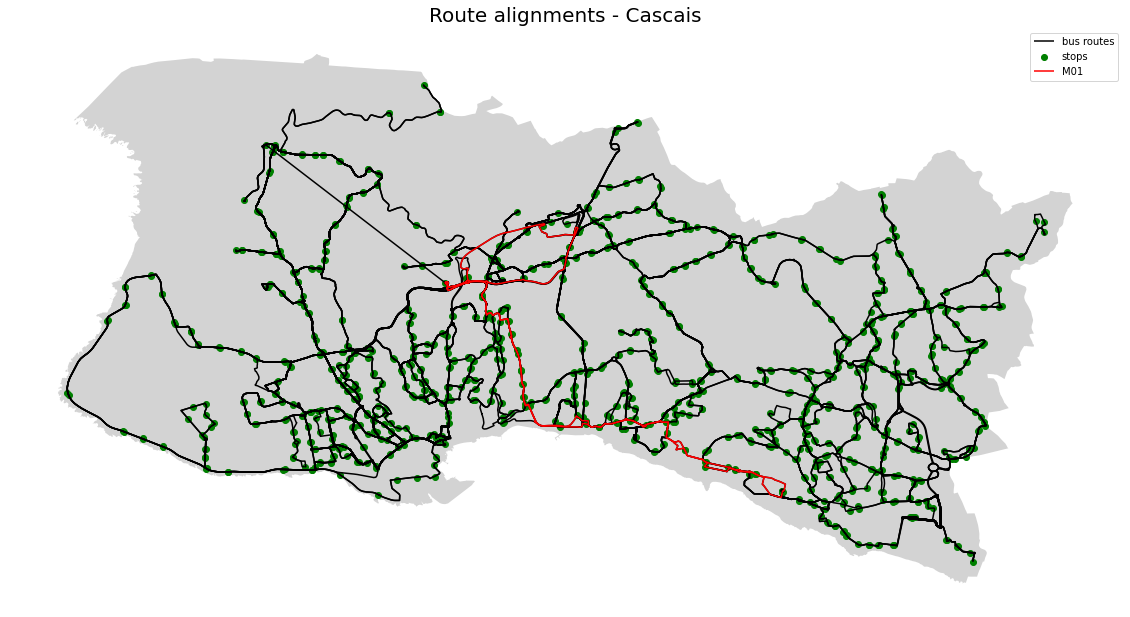

In [37]:
fig, ax = plt.subplots(figsize = (20,15))

# Cascais boundaries from open street map
ox.geocode_to_gdf({'city': 'Cascais'}).plot(
    ax=ax, color='lightgrey'
)

# Bus routes data
geo_shapes_by_id.plot(
    ax=ax, color='black', label="bus routes"
)

# Bus stops geo data
geo_stops.plot(
    ax=ax, color='green', label="stops"
)

# Highlight the shapes of a route
route_id = "M01" # Choose the route you prefer :)
geo_shapes_by_id.loc[
  geo_shapes_by_id.routes.apply(lambda x: x==route_id)
].plot(
    ax=ax, color='red', label=route_id
)

ax.legend()
plt.title('Route alignments - Cascais', size=20)
plt.axis('off')
plt.show()

### Bus Routes

[source](https://dadosabertos.cascais.pt/dataset/carreira-de-autocarro)


#### Data request



```
!wget https://dadosabertos.cascais.pt/pt_PT/dataset/c638230c-d66e-4756-b170-fb69877fb65b/resource/28b61a85-6239-4f42-8361-510025494a36/download/mncarreiraautocarro.csv \
    -O data/bus_routes.csv \
    --no-check-certificate
```



```
!wget https://dadosabertos.cascais.pt/pt_PT/dataset/c638230c-d66e-4756-b170-fb69877fb65b/resource/3efe9620-962c-45b5-acde-2436ac1c274c/download/mncarreiraautocarro.geojson \
    -O data/bus_routes.geojson \
    --no-check-certificate
```

#### Data description

[Description source](https://docs.google.com/spreadsheets/d/10IUS4sdJPEgGHunAlUyG50ww2Kntt69MFSnePL5h-BU/edit#gid=850019181)

"Delimitation of the routes of the municipal road transport network.
Routes sometimes are divided into different sections but can be joined 
by referencing the ""carreira"" column to get the total path of a route."

#### EDA

In [38]:
df_bus_routes = pd.read_csv(
    os.path.join(dataPath, "bus_routes.csv"),
    encoding = "ISO-8859-1", sep=","
)

# Drop columns with all NaN values
df_bus_routes = df_bus_routes.dropna(how='all', axis=1)

# Rename columns
df_bus_routes.rename(
    columns = {
        'Id':'id',
        'Operador':'operator',
        'Data de actualização': 'date_of_execution',
        'Carreira': 'route_id',
        'Origem': 'origin'
    },
    inplace = True
)

# Convert "Data de actualização" to datetime
df_bus_routes.loc[:, "date_of_execution"] = pd.to_datetime(
    df_bus_routes.loc[:, "date_of_execution"], format="%d/%m/%Y %H:%M:%S"
)

# Show dataset
df_bus_routes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 776 non-null    int64         
 1   operator           776 non-null    object        
 2   date_of_execution  776 non-null    datetime64[ns]
 3   route_id           776 non-null    object        
 4   origin             776 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 30.4+ KB


In [39]:
# Number of unique values per column
df_bus_routes.nunique(dropna=False)

id                   776
operator               3
date_of_execution    203
route_id              53
origin                91
dtype: int64

In [40]:
df_bus_routes["date_of_execution"].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                     776
unique                    203
top       2021-05-25 12:51:09
freq                       28
first     2021-05-25 11:48:45
last      2021-05-25 12:51:47
Name: date_of_execution, dtype: object

#### Geo data

In [41]:
geo_bus_routes = gpd.read_file(
    os.path.join(dataPath, "bus_routes.geojson")
)

# Rename columns
geo_bus_routes.rename(
    columns = {
        'Geometry name': 'geometry_name',
        'Operador':'operator',
        'Data de actualização': 'date_of_execution',
        'Carreira': 'route_id',
        'Origem': 'origin'
    },
    inplace = True
)

# Convert "Data de actualização" to datetime
geo_bus_routes.loc[:, "date_of_execution"] = pd.to_datetime(
    geo_bus_routes.loc[:, "date_of_execution"], format="%d/%m/%Y %H:%M:%S"
)

In [42]:
geo_bus_routes.head()

,geometry_name,operator,date_of_execution,route_id,origin,geometry
0,Posição,Martin,2021-05-25 11:48:45,M01,M01 Parede Terminal - CascaiShopping via Estoril,"LINESTRING (-9.35919 38.69203, -9.35911 38.691..."
1,Posição,Martin,2021-05-25 11:49:35,M01,M01 Parede Terminal - CascaiShopping via Estoril,"LINESTRING (-9.40120 38.73883, -9.40188 38.738..."
2,Posição,Martin,2021-05-25 11:50:24,M33,M33 Sassoeiros - Tires (Circular),"LINESTRING (-9.32934 38.71005, -9.32798 38.708..."
3,Posição,Martin,2021-05-25 11:50:46,M33,M33 Sassoeiros - Tires (Circular),"LINESTRING (-9.32978 38.71051, -9.32981 38.710..."
4,Posição,Martin,2021-05-25 11:50:49,M02,M02 Cascais Estação - Malveira (Circular) - A,"LINESTRING (-9.42002 38.70153, -9.41968 38.701..."


### Interventions in public roads

[source](https://dadosabertos.cascais.pt/dataset/obras-de-intervencao-na-via-publica)

#### Data request



```
!wget https://dadosabertos.cascais.pt/pt_PT/dataset/0d9193e7-aa5f-4c18-b826-55b11965acd4/resource/88cdf865-0955-4629-9019-12d36fb48693/download/mnivp.csv \
    -O data/interventions_in_public_roads.csv \
    --no-check-certificate
```



#### Data description

[Description source](https://docs.google.com/spreadsheets/d/10IUS4sdJPEgGHunAlUyG50ww2Kntt69MFSnePL5h-BU/edit#gid=850019181)

"Contains information about interventions on public roads."

#### EDA

In [47]:
# Interventions in public roads
df_interventions = pd.read_csv(
    os.path.join(dataPath, "interventions_in_public_roads.csv"),
    encoding = "ISO-8859-1", sep=";"
)

# Rename columns
df_interventions.rename(
    columns = {
        'Id':'id',
        'Requerente':'applicant ',
        'Tipo de Trabalho': 'type_of_work',
        'Rua': 'street',
        'Freguesia': 'parish',
        'Data de actualização': 'date_of_execution',
        'Data Prevista de Inicio': 'forecasted_starting_date',
        'Data Prevista de Fim': 'forecasted_end_date',
        'Número do Processo': "code_number",
        'Estado': 'status',
        'Recepção Provisória': 'provisional_reception',
        'Ano': 'year',
        'Recepção Definitiva': 'definitive_reception'
    },
    inplace = True
)

# Convert "date_of_execution" to datetime
df_interventions.loc[:, "date_of_execution"] = pd.to_datetime(
    df_interventions.loc[:, "date_of_execution"], format="%d-%m-%Y %H:%M"
)

# Show dataset info
df_interventions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6617 entries, 0 to 6616
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id                        6617 non-null   int64         
 1   applicant                 6617 non-null   object        
 2   type_of_work              6617 non-null   object        
 3   street                    6561 non-null   object        
 4   parish                    6561 non-null   object        
 5   date_of_execution         6617 non-null   datetime64[ns]
 6   forecasted_starting_date  6596 non-null   object        
 7   forecasted_end_date       6599 non-null   object        
 8   code_number               4764 non-null   object        
 9   status                    6617 non-null   object        
 10  provisional_reception     1480 non-null   object        
 11  year                      6614 non-null   object        
 12  definitive_reception

In [48]:
# Dataset view
df_interventions.head(5)

,id,applicant,type_of_work,street,parish,date_of_execution,forecasted_starting_date,forecasted_end_date,code_number,status,provisional_reception,year,definitive_reception
0,44611945,Particular,Rede elétrica,Rua das Amendoeiras,U.F. Carcavelos e Parede,2020-06-02 09:15:00,24-04-2020,24-04-2020,WW227609,Em execução,NaN,2020,NaN
1,44522015,Particular,Rede elétrica,Rua do Bugio,U.F. Carcavelos e Parede,2020-04-06 13:20:00,14-04-2020,13-04-2020,WW226781,Em execução,NaN,2020,NaN
2,44514495,Particular,Rede elétrica,Rua das Amendoeiras,U.F. Carcavelos e Parede,2020-03-12 09:38:00,16-03-2020,20-03-2020,WW224828,Em execução,NaN,2020,NaN
3,46640212,Particular,Rede elétrica,"Travessa Nuno Tristão, n.1 em Murches",Alcabideche,2021-05-11 15:52:00,18-05-2021,19-05-2021,WW272199,Em execução,NaN,2021,NaN
4,40717062,ADC Águas de Cascais,Rede elétrica,Caminho do Uruguai,Alcabideche,2018-01-24 12:13:00,29-01-2018,09-02-2018,IVP/0009/18,Em execução,12-02-2018,2018,12-02-2021


In [49]:
# Number of unique values per column
df_interventions.nunique(dropna=False)

id                          6617
applicant                     10
type_of_work                   9
street                      2706
parish                         5
date_of_execution           6509
forecasted_starting_date    1447
forecasted_end_date         1369
code_number                 4704
status                         7
provisional_reception        540
year                          10
definitive_reception         541
dtype: int64

##### Interventions per parish

Let us sort the parishes by the overall number of interventions:

In [50]:
# Type of interventions per parish
df_interventions.groupby(
   "parish"
).size().to_frame('num_of_works')

,num_of_works
parish,
Alcabideche,1051
São Domingos de Rana,1392
U.F. Carcavelos e Parede,981
U.F. Cascais e Estoril,3137


In [ ]:
# Time series dataframe
ts_interventions = df_interventions.sort_values('date_of_execution')
ts_interventions.index = ts_interventions['date_of_execution']
ts_interventions.drop('date_of_execution', axis=1, inplace=True)

# Choose resample
resample_freq = 'M' # D, M, Y

fig = px.line(
    ts_interventions.groupby(
        'parish'
    ).resample(resample_freq).id.count().reset_index(),
    x='date_of_execution', y="id", color='parish',
    labels={"parish": "parish id", "date_of_execution": "date",
            "id": "n. of interventions"},
    title=f"Time series of n. of interventions per parish"
)

fig.show()

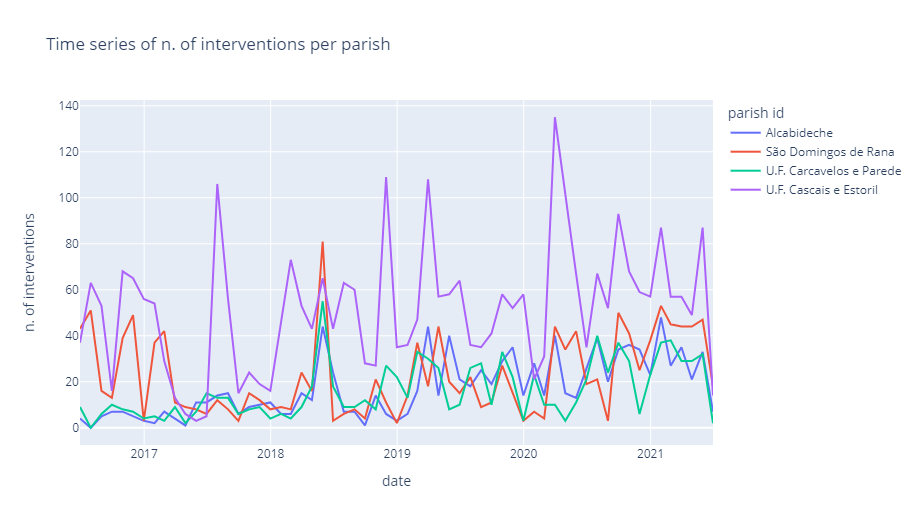

##### Interventions per type of work

Looking at the number of interventions per type of work:

In [52]:
# Type of interventions per parish
df_interventions.groupby(
   "type_of_work"
).size().to_frame('num_of_works').sort_values(
    by='num_of_works', ascending=False)

,num_of_works
type_of_work,
Rede de abastecimento de água,4203
Rede elétrica,897
Rede de gás,569
Rede de telecomunicações,340
Rede de abastecimento de água+residuais,292
Rede águas residuais domésticas,167
Rede de águas pluviais,58
Rede de águas pluviais + residuais,53
Outra,38


In [ ]:
# Time series dataframe
ts_interventions = df_interventions.sort_values('date_of_execution')
ts_interventions.index = ts_interventions['date_of_execution']
ts_interventions.drop('date_of_execution', axis=1, inplace=True)

# Choose resample
resample_freq = 'M' # D, M, Y

fig = px.line(
    ts_interventions.groupby(
        'type_of_work'
    ).resample(resample_freq).id.count().reset_index(),
    x='date_of_execution', y="id", color='type_of_work',
    labels={"type_of_work": "type of work", "date_of_execution": "date",
            "id": "n. of interventions"},
    title=f"Time series of n. of interventions per type of work"
)

fig.show()

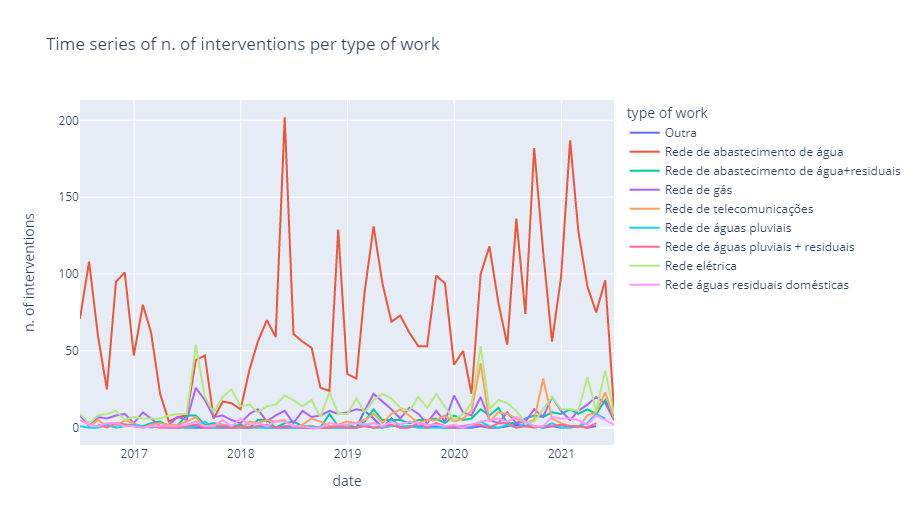

In [54]:
# Type of interventions per parish
df_interventions.groupby(
    ["type_of_work", "parish"]
).size().to_frame('num_of_works')

num_of_works
type_of_work                            parish                                
Outra                                   Alcabideche                         20
                                        São Domingos de Rana                 6
                                        U.F. Carcavelos e Parede             2
                                        U.F. Cascais e Estoril               9
Rede de abastecimento de água           Alcabideche                        649
                                        São Domingos de Rana               930
                                        U.F. Carcavelos e Parede           615
                                        U.F. Cascais e Estoril            1984
Rede de abastecimento de água+residuais Alcabideche                         48
                                        São Domingos de Rana                81
                                        U.F. Carcavelos e Parede            32
                                        U.F. Cascais e Estoril             125
Rede de gás                             Alcabideche                         70
                                        São Domingos de Rana               112
                                        U.F. Carcavelos e Parede           116
                                        U.F. Cascais e Estoril             268
Rede de telecomunicações                Alcabideche                         50
                                        São Domingos de Rana                46
                                        U.F. Carcavelos e Parede            43
                                        U.F. Cascais e Estoril             190
Rede de águas pluviais                  Alcabideche                         13
                                        São Domingos de Rana                 7
                                        U.F. Carcavelos e Parede            12
                                        U.F. Cascais e Estoril              25
Rede de águas pluviais + residuais      Alcabideche                         11
                                        São Domingos de Rana                 3
                                        U.F. Carcavelos e Parede            16
                                        U.F. Cascais e Estoril              20
Rede elétrica                           Alcabideche                        166
                                        São Domingos de Rana               177
                                        U.F. Carcavelos e Parede           127
                                        U.F. Cascais e Estoril             423
Rede águas residuais domésticas         Alcabideche                         24
                                        São Domingos de Rana                30
                                        U.F. Carcavelos e Parede            18
                                        U.F. Cascais e Estoril              93

In [55]:
# Type of interventions and their status
df_interventions.groupby(
    ["type_of_work", "status"]
).size().to_frame('num_of_works')

num_of_works
type_of_work                            status                                         
Outra                                   Em execução                                  18
                                        Outro                                        10
                                        Receção Provisória (Executado)               10
Rede de abastecimento de água           Anulado                                       3
                                        Em execução                                1283
                                        Em licenciamento                             32
                                        Histórico                                     2
                                        Outro                                        54
                                        Receção Definitiva (Fim Garantia)             2
                                        Receção Provisória (Executado)             2827
Rede de abastecimento de água+residuais Em execução                                 157
                                        Em licenciamento                             13
                                        Histórico                                     1
                                        Receção Provisória (Executado)              121
Rede de gás                             Anulado                                       2
                                        Em execução                                 280
                                        Em licenciamento                             25
                                        Outro                                         6
                                        Receção Provisória (Executado)              256
Rede de telecomunicações                Anulado                                       2
                                        Em execução                                 140
                                        Em licenciamento                             23
                                        Outro                                         3
                                        Receção Provisória (Executado)              172
Rede de águas pluviais                  Anulado                                       1
                                        Em execução                                  33
                                        Em licenciamento                              1
                                        Histórico                                     1
                                        Receção Provisória (Executado)               22
Rede de águas pluviais + residuais      Em execução                                  33
                                        Em licenciamento                              1
                                        Receção Provisória (Executado)               19
Rede elétrica                           Anulado                                       3
                                        Em execução                                 466
                                        Em licenciamento                             24
                                        Histórico                                     1
                                        Outro                                         3
                                        Receção Provisória (Executado)              400
Rede águas residuais domésticas         Em execução                                  67
                                        Em licenciamento                              6
                                        Receção Provisória (Executado)               94

#### Request geocode data 

The road intervention dataset shows the address where the work takes place, but does not provide us with geospatial details.

Some of the interventions can be matched with the stop dataframe by means of the stop name.

To display the location of all interventions, we use the Google Map API service for geocoding.

In [56]:
if not os.path.exists(
    os.path.join(dataPath, 'street_interventions_geocoding.pickle')
    ):

    # User API key
    google_api_key = input('Enter your Google API key: ')

    # Google Map API service
    gmaps = googlemaps.Client(key=google_api_key)

    # Initializing {street: geocode} dict
    street_geocode = dict()

    # Unique streets
    unique_streets = df_interventions.street.unique()

    for i, street_name in enumerate(unique_streets):
        logging.info(f"Iteratiion {i}\t Street: {street_name}")

        # Geocoding an address
        address = f'{street_name}, Cascais, Portugal'
        geocode_result = gmaps.geocode(address)

        # Update dict
        street_geocode[street_name] = geocode_result

    # Save geocoding results with pickle
    with open(
        os.path.join(dataPath, 'street_interventions_geocoding.pickle', 'wb')
        ) as f:
        pickle.dump(street_geocode, f, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
# Load geocoding data
with open(
    os.path.join(dataPath, 'street_interventions_geocoding.pickle'), 'rb'
    ) as f:
    street_geocode = pickle.load(f)

In [58]:
# Extracting locations coordinates from geocode data
street_interventions_locations = []

for street, geocode in street_geocode.items():
    location = geocode[0]['geometry']['location']
    latitude = location['lat']
    longitude = location['lng']
    street_interventions_locations.append(
        (street, location, latitude, longitude)
    )

df_street_interventions_locations = pd.DataFrame.from_records(
    street_interventions_locations,
    columns=["street", "location", "latitude", "longitude"]
)

In [59]:
df_street_interventions_locations.head(5)

,street,location,latitude,longitude
0,Rua das Amendoeiras,"{'lat': 38.7048309, 'lng': -9.4414765}",38.704831,-9.441477
1,Rua do Bugio,"{'lat': 38.7164011, 'lng': -9.3244222}",38.716401,-9.324422
2,"Travessa Nuno Tristão, n.1 em Murches","{'lat': 38.731979, 'lng': -9.4379791}",38.731979,-9.437979
3,Caminho do Uruguai,"{'lat': 38.7553125, 'lng': -9.441408}",38.755313,-9.441408
4,"Rua do Pinhal, n.º 762 em Outeiro de Polima","{'lat': 38.7150883, 'lng': -9.3255888}",38.715088,-9.325589


In [60]:
# Merging interventions and street locations dataframes
df_interventions_and_coordinates = df_interventions.merge(
    df_street_interventions_locations, on="street", how="left"
)

In [61]:
# Mask locations out of shapes bounds
mask_locations_out_of_bounds = (
    
    # Latitude bounds
    (df_interventions_and_coordinates.latitude<df_shapes.shape_pt_lat.min()) |
    (df_interventions_and_coordinates.latitude>df_shapes.shape_pt_lat.max()) |

    # Longitude bounds
    (df_interventions_and_coordinates.longitude<df_shapes.shape_pt_lon.min()) |
    (df_interventions_and_coordinates.longitude>df_shapes.shape_pt_lon.max())

)

In [62]:
# Look at locations out of shapes bounds
df_interventions_and_coordinates.loc[
    mask_locations_out_of_bounds
].head(5)

,id,applicant,type_of_work,street,parish,date_of_execution,forecasted_starting_date,forecasted_end_date,code_number,status,provisional_reception,year,definitive_reception,location,latitude,longitude
141,40062654,EDP,Rede elétrica,Estrada Octávio Pato,São Domingos de Rana,2017-11-08 15:57:00,13-11-2017,15-12-2017,IVP/0521/17,Em execução,NaN,2017,NaN,"{'lat': 38.7460298, 'lng': -9.3121376}",38.746030,-9.312138
417,43887380,Particular,Rede elétrica,Praça Dr. Carlos Alberto Rosa,U.F. Cascais e Estoril,2020-02-12 17:10:00,11-03-2019,13-03-2019,NaN,Receção Provisória (Executado),NaN,2019,NaN,"{'lat': 39.39987199999999, 'lng': -8.224454}",39.399872,-8.224454
426,44490363,Outro,Rede elétrica,Rua do Comércio,São Domingos de Rana,2020-03-03 11:51:00,07-02-2020,07-02-2020,WW220109,Em execução,NaN,2020,NaN,"{'lat': 38.7366808, 'lng': -9.3117298}",38.736681,-9.311730
435,39027605,Particular,Rede elétrica,Rua de Calígula,São Domingos de Rana,2016-11-28 11:18:00,05-12-2016,05-12-2016,IVP/0494/16,Em execução,NaN,2016,NaN,"{'lat': 38.7388502, 'lng': -9.3110576}",38.738850,-9.311058
524,46632776,Outro,Rede elétrica,Rua do Comércio,São Domingos de Rana,2021-05-12 14:36:00,07-06-2021,07-06-2021,ww271247,Em execução,NaN,2021,NaN,"{'lat': 38.7366808, 'lng': -9.3117298}",38.736681,-9.311730


In [63]:
# Mask locations within shapes bounds
mask_locations_within_bounds = (
    
    # Latitude bounds
    (df_interventions_and_coordinates.latitude>=df_shapes.shape_pt_lat.min()) &
    (df_interventions_and_coordinates.latitude<=df_shapes.shape_pt_lat.max()) &

    # Longitude bounds
    (df_interventions_and_coordinates.longitude>=df_shapes.shape_pt_lon.min()) &
    (df_interventions_and_coordinates.longitude<=df_shapes.shape_pt_lon.max())

)

In [64]:
# Keep locations within bounds
df_interventions_and_coordinates = df_interventions_and_coordinates.loc[
    mask_locations_within_bounds
]

In [65]:
# Group data by latitude and longitude
df_grouped_by_coordinates = df_interventions_and_coordinates.groupby(
    ["latitude", "longitude"]
).size().to_frame("num_interventions").reset_index()

#### Geo data

In [66]:
def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
    # create a new python dict to contain our geojson data, using geojson format
    geojson = {'type':'FeatureCollection', 'features':[]}

    # loop through each row in the dataframe and convert each row to geojson format
    for _, row in df.iterrows():
        # create a feature template to fill in
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}

        # fill in the coordinates
        feature['geometry']['coordinates'] = [row[lon],row[lat]]

        # for each column, get the value and add it as a new feature property
        for prop in properties:
            feature['properties'][prop] = row[prop]
        
        # add this feature (aka, converted dataframe row) to the list of features inside our dict
        geojson['features'].append(feature)
    
    return geojson

In [67]:
if not os.path.exists(
    os.path.join(dataPath, 'street_interventions_coordinates.geojson')
    ):

    # geo interventions dataframe to geojson
    geo_interventions_and_coordinates = df_to_geojson(
        df_grouped_by_coordinates,
        properties = ["num_interventions"],
    )

    with open(
        os.path.join(dataPath, 'street_interventions_coordinates.geojson')
    ) as f:
        json.dump(geo_interventions_and_coordinates, f)

In [68]:
# Load geojson data with geo pandas
geo_interventions_and_coordinates = gpd.read_file(
    os.path.join(dataPath, "street_interventions_coordinates.geojson")
)

In [69]:
geo_interventions_and_coordinates.head(5)

,num_interventions,geometry
0,2.0,POINT (-9.32940 38.68037)
1,5.0,POINT (-9.32548 38.68041)
2,2.0,POINT (-9.33039 38.68077)
3,1.0,POINT (-9.33056 38.68078)
4,1.0,POINT (-9.32916 38.68226)


In [70]:
# Group data by latitude, longitude and type of intervention
df_grouped_by_coordinates_and_type = df_interventions_and_coordinates.groupby(
    ["latitude", "longitude", "type_of_work"]
).size().to_frame("num_interventions").reset_index()

In [71]:
if not os.path.exists(
    os.path.join(dataPath, 'street_interventions_coordinates_and_type.geojson')
    ):

    # geo interventions dataframe to geojson
    geo_interventions_and_coordinates = df_to_geojson(
        df_grouped_by_coordinates_and_type,
        properties = ["type_of_work","num_interventions"],
    )

    with open(
        os.path.join(dataPath, 'street_interventions_coordinates_and_type.geojson'), 'w', encoding="ISO-8859-1"
    ) as f:
        json.dump(geo_interventions_and_coordinates, f)

In [72]:
# Load geojson data with geo pandas
geo_interventions_coordinates_and_type = gpd.read_file(
    os.path.join(dataPath, "street_interventions_coordinates_and_type.geojson"),  encoding="ISO-8859-1"
)

In [73]:
# zoom points
geo_interventions_coordinates_and_type.num_interventions = geo_interventions_coordinates_and_type.num_interventions*10

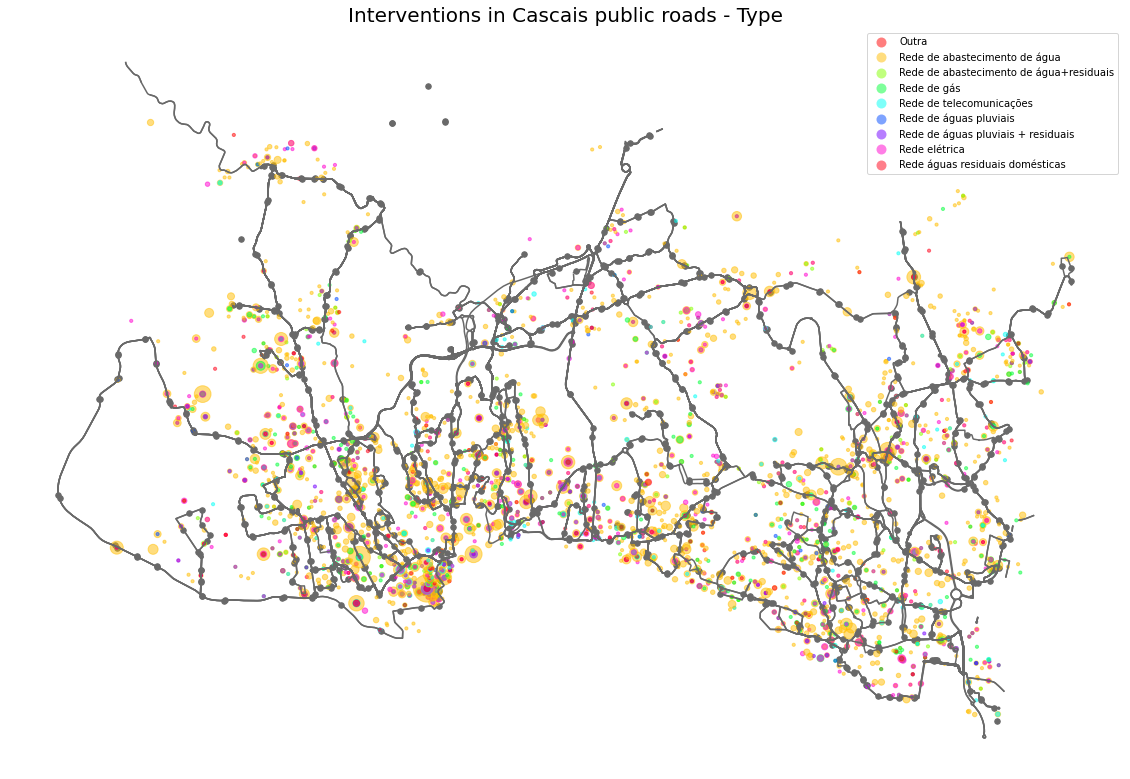

In [75]:
fig, ax = plt.subplots(figsize = (20,15))


# stops Internventions coordinates
geo_stops.plot(
    ax=ax, color='dimgray', markersize=30,  legend = True, label = 'bus'
)


# Bus routes data
geo_bus_routes.plot(
    ax=ax, figsize=(20, 15), color = 'dimgray' #column='operator',figsize=(20, 15), cmap = 'inferno', legend=True
)


# Internventions coordinates
geo_interventions_coordinates_and_type.plot(
    ax=ax, column='type_of_work', alpha = 0.5, cmap = 'hsv', markersize="num_interventions",  legend=True
)

plt.title('Interventions in Cascais public roads - Type', size=20)
plt.axis('off')
plt.show()

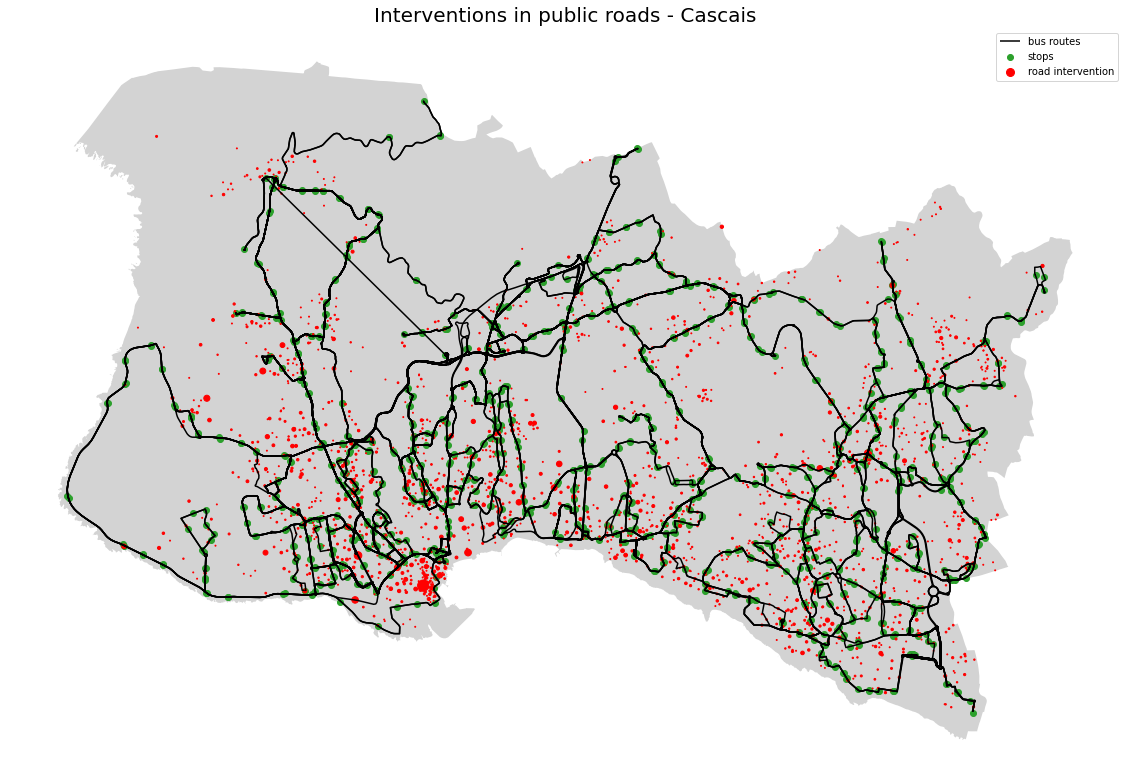

In [76]:
fig, ax = plt.subplots(figsize = (20,15))

# Cascais boundaries from open street map
ox.geocode_to_gdf({'city': 'Cascais'}).plot(
    ax=ax, color='lightgrey'
)

# Bus routes data
geo_shapes_by_id.plot(
    ax=ax, color='black', label="bus routes"
)

# Bus stops geo data
geo_stops.plot(
    ax=ax, color='C2', label="stops"
)

# Internventions coordinates
geo_interventions_and_coordinates.plot(
    ax=ax, color='red', markersize="num_interventions",
    label="road intervention"
)

ax.legend()
plt.title('Interventions in public roads - Cascais', size=20)
plt.axis('off')
plt.show()

### Stops and interventions

Let us now focus on the analysis of the interventions occurring on roads where bus stops are located.

In [78]:
# Merge interventions with stops info
df_interventions_and_stops = pd.merge(
    df_interventions, df_stops,
    how='inner', left_on="street", right_on="stop_name"
)

In [79]:
# Group interventions by stop name and count the total number of interventions
interventions_by_stop_name = df_interventions_and_stops.groupby(
    ["stop_name", "stop_lat", "stop_lon", "parish"]).size().to_frame(
        "number_of_works").sort_values(
            by="number_of_works", ascending=False).reset_index()

In [80]:
# To GeoDataframe
interventions_geometry = [
    Point(xy) for xy in zip(
        interventions_by_stop_name.stop_lon,
        interventions_by_stop_name.stop_lat
    )
]

geo_interventions_by_stop_name = gpd.GeoDataFrame(
    interventions_by_stop_name, geometry=interventions_geometry
)

In [81]:
geo_interventions_by_stop_name

,stop_name,stop_lat,stop_lon,parish,number_of_works,geometry
0,Rua Joaquim Ereira,38.706715,-9.437499,U.F. Cascais e Estoril,20,POINT (-9.43750 38.70672)
1,Rua Joaquim Ereira,38.706613,-9.437512,U.F. Cascais e Estoril,20,POINT (-9.43751 38.70661)
2,Rua Principal,38.739086,-9.437846,São Domingos de Rana,16,POINT (-9.43785 38.73909)
3,Rua Principal,38.738940,-9.437731,São Domingos de Rana,16,POINT (-9.43773 38.73894)
4,Estrada da Ribeira,38.724712,-9.415380,Alcabideche,15,POINT (-9.41538 38.72471)
...,...,...,...,...,...,...
263,Rua Gil Eanes,38.728855,-9.444405,Alcabideche,1,POINT (-9.44440 38.72886)
264,Rua Francisco Roquete,38.732737,-9.409292,Alcabideche,1,POINT (-9.40929 38.73274)
265,Rua Francisco Cruz,38.718052,-9.421662,Alcabideche,1,POINT (-9.42166 38.71805)
266,Rua Florêncio Freire,38.742007,-9.341268,São Domingos de Rana,1,POINT (-9.34127 38.74201)


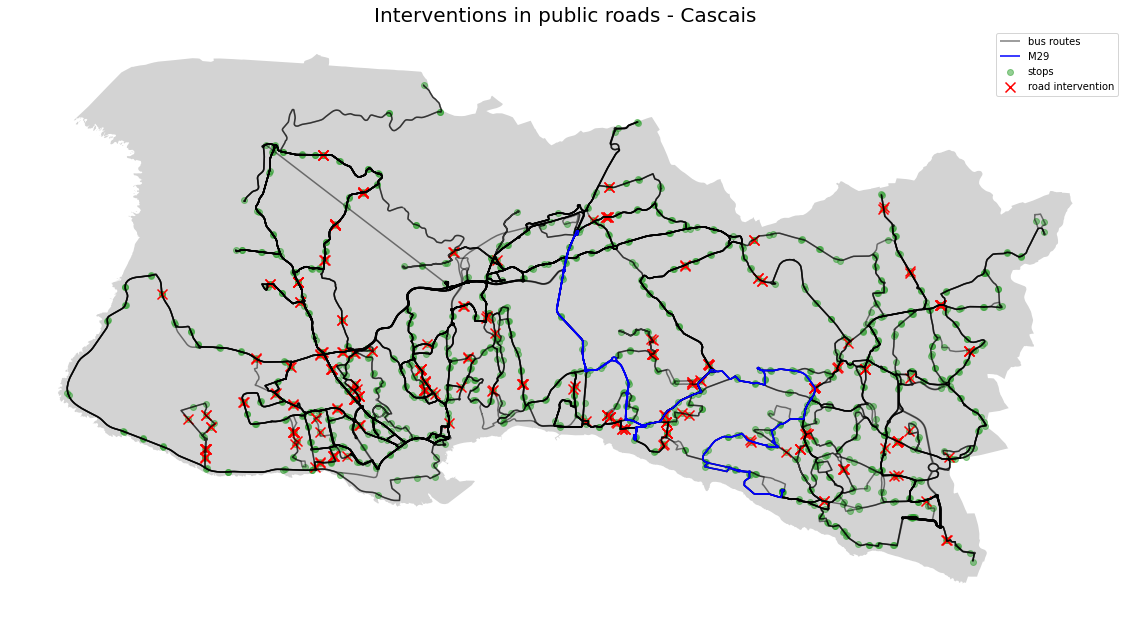

In [82]:
fig, ax = plt.subplots(figsize = (20,15))

# Cascais boundaries from open street map
ox.geocode_to_gdf({'city': 'Cascais'}).plot(
    ax=ax, color='lightgrey'
)

# Bus routes data
geo_shapes_by_id.plot(
    ax=ax, color='black', label="bus routes", alpha=0.5
)

# Highlight the shapes of a route
route_id = "M29" # Choose the route here :)
geo_shapes_by_id.loc[
  geo_shapes_by_id.routes.apply(lambda x: route_id in x)
].plot(
    ax=ax, color='blue', label=route_id
)

# Bus stops geo data
geo_stops.plot(
    ax=ax, color='C2', label="stops", alpha=0.5
)

# Internventions coordinates
geo_interventions_by_stop_name.plot(
    ax=ax, color='red', markersize=100,
    marker='x', label="road intervention"
)

ax.legend()
plt.title('Interventions in public roads - Cascais', size=20)
plt.axis('off')
plt.show()

Although in this example we plot all breaks that have been recorded in the dataset, in general road works may prevent buses from serving one or more stops. We therefore have to look for a solution that is flexible to re-routing buses in case of multiple interruptions.

### Bus routes optimization

At this point we asked ourselves how to mathematically define the requested optimization problem. We immediately thought about the possible metrics to be minimized or maximized in an ideal, but really feasible solution. Should we optimize on the number of lost bus stops, on the overall path length… either on the cumulative delay time or considering user demand and experience?
We propose a simplified but easily generalizable solution to the problem: optimizing the route of a single bus line in terms of distance travelled. 
In practice we have represented the bus route on a direct graph, dropping nodes affected by road maintenance. At this point we used the Dijkstras’s algorithm to find the best path between the line stops remained disconnected. In doing this, the algorithms is allowed to consider closer alternative stops depending on the distance returned by the Google Maps Directions API.

#### Pairwise stop distances

Let's start by finding out which stops are closest to each other. To do this, we should calculate all distances (in terms of road route or travel time) between all possible stops on all routes.

However, due to the limitations of the available services (credits for Google, time for Open route service), we filter the possibilities by calculating the approximate distance as the Euclidean distance of the stop coordinates.

In [83]:
from scipy.spatial.distance import pdist

In [84]:
# Compute stops euclidean pairwise distances
stops_coordinates = df_stops[["stop_lat", "stop_lon"]].to_numpy()
pairwise_distances = pdist(stops_coordinates, metric="euclidean")

From scipy documentation:

pdist returns a condensed distance matrix Y. For each *i* and *j* (where *i<j<m*),where *m* is the number of original observations. The metric dist(u=X[i], v=X[j]) is computed and stored in entry m * i + j - ((i + 2) * (i + 1)) // 2.

In [85]:
# Function to get index of stored pairwise distances according to scipy pdist
def dist_ind(m, i , j):
    assert i!=j, f"Invalid inputs: i={i}, j={j}. i!=j required"
    if i > j:
        # swap values
        i, j = j, i
    assert j<m, f"After swap: i={i}, j={j}, m={m}. j<m required"
    index = m * i + j - ((i + 2) * (i + 1)) // 2
    return index

In [86]:
# Create dataframe of distances
num_stops = df_stops.shape[0]
records_dist = list()

for i in range(num_stops):
    stop_id_i = df_stops.stop_id.iloc[i]
    for j in range(num_stops):
        if i==j:
            continue
        stop_id_j = df_stops.stop_id.iloc[j]
        dist_i_j = pairwise_distances[dist_ind(num_stops, i , j)]
        records_dist.append(
            {
                "from_stop": stop_id_i,
                "to_stop": stop_id_j,
                "dist": dist_i_j
            }
        )

df_pairwise_distances = pd.DataFrame.from_records(records_dist)

In [87]:
df_pairwise_distances.head()

,from_stop,to_stop,dist
0,155956,155879,0.000657
1,155956,5066,0.019843
2,155956,5064,0.006469
3,155956,5067,0.019961
4,155956,5063,0.063824


In [88]:
# From stop to stop sorted distances dataframe
df_sorted_distances_from_stop = df_pairwise_distances.copy()

df_sorted_distances_from_stop["to_stop_dist"] = list(
    zip(
        df_sorted_distances_from_stop.to_stop,
        df_sorted_distances_from_stop.dist
    )
)

df_sorted_distances_from_stop = df_sorted_distances_from_stop.groupby(
    ["from_stop"]).agg(to_stop_dist = (
        "to_stop_dist",
        lambda x: sorted(list(x), key=lambda k: k[1])
    ))

df_sorted_distances_from_stop.head()

,to_stop_dist
from_stop,
5002,"[(5003, 0.001303371397569517), (156352, 0.0020..."
5003,"[(156350, 0.0011951677706493872), (156315, 0.0..."
5004,"[(5005, 0.00010592922165255611), (156352, 0.00..."
5005,"[(5004, 0.00010592922165255611), (156352, 0.00..."
5006,"[(5007, 0.00029276953393908404), (156106, 0.00..."


Let's look at an example

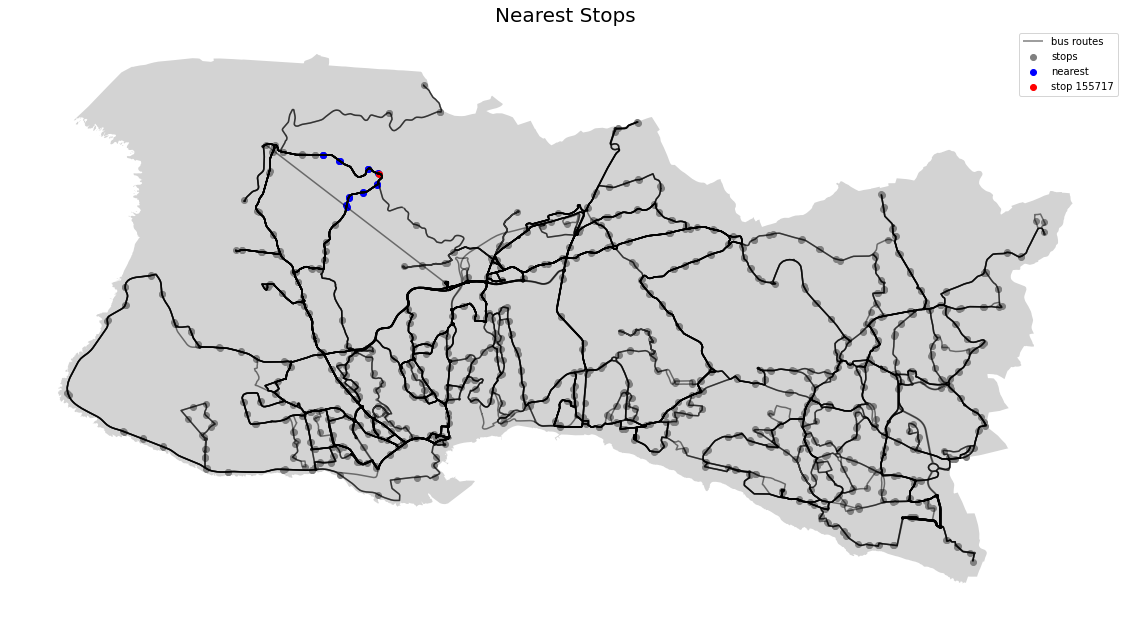

In [89]:
fig, ax = plt.subplots(figsize = (20,15))

# Cascais boundaries from open street map
ox.geocode_to_gdf({'city': 'Cascais'}).plot(
    ax=ax, color='lightgrey'
)

# Bus routes data
geo_shapes_by_id.plot(
    ax=ax, color='black', label="bus routes", alpha=0.5
)

# Bus stops geo data
geo_stops.plot(
    ax=ax, color='grey', label="stops"
)

# Choose stop
stop_id = 155717

# Nearest stops
nearest_stops = [
    k[0] for k in df_sorted_distances_from_stop.loc[
        df_sorted_distances_from_stop.index==stop_id
    ].to_stop_dist.values[0][:15]
]
geo_stops.loc[geo_stops.stop_id.isin(nearest_stops)].plot(
    ax=ax, color='blue', label="nearest"
)
geo_stops.loc[geo_stops.stop_id == stop_id].plot(
    ax=ax, color='red', label=f"stop {stop_id}"
)

ax.legend()
plt.title('Nearest Stops', size=20)
plt.axis('off')
plt.show()

#### Graph definition

In [90]:
# Pandas DataFrame containing edge list
df_edgelist = df_stop_times[
    ["trip_id"]
].copy()

df_edgelist["source"] = df_stop_times["stop_id"]
df_edgelist["target"] = df_stop_times["stop_id"]
df_edgelist["shape_dist"] = df_stop_times["shape_dist_traveled"] - \
    df_stop_times.groupby("trip_id")["shape_dist_traveled"].shift(1)

df_edgelist["source"] = df_edgelist.groupby("trip_id")["source"].shift(1)
df_edgelist.dropna(inplace=True)

df_edgelist["source"] = df_edgelist["source"].astype(int)

In [91]:
df_edgelist.head()

,trip_id,source,target,shape_dist
1,M01-1-001-A-U-09h15-ParedeTerminalR,200037,155665,667.36
2,M01-1-001-A-U-09h15-ParedeTerminalR,155665,155666,364.06
3,M01-1-001-A-U-09h15-ParedeTerminalR,155666,155667,475.68
4,M01-1-001-A-U-09h15-ParedeTerminalR,155667,155668,435.98
5,M01-1-001-A-U-09h15-ParedeTerminalR,155668,155669,506.36


In [92]:
# Networkx graph
G_main = nx.from_pandas_edgelist(
    df = df_edgelist, source = 'source', target = 'target',
    edge_attr = ['shape_dist'], create_using = nx.DiGraph()
)

In [93]:
# Nodes attributes
stop_geometries = {
    row.stop_id: (row.stop_lon, row.stop_lat) for _, row in df_stops.iterrows()
}
stop_names = {row.stop_id: row.stop_name for _, row in df_stops.iterrows()}

#### Intervention simulation

Let us choose a trip to optimize:

In [94]:
# Select a trip
trip_to_optimize = "M29-2-025-A-U-15h20-CascaiShoppingT"

In [95]:
df_edgelist.loc[df_edgelist.trip_id == trip_to_optimize]

,trip_id,source,target,shape_dist
111055,M29-2-025-A-U-15h20-CascaiShoppingT,156309,156310,299.69
111056,M29-2-025-A-U-15h20-CascaiShoppingT,156310,155909,310.45
111057,M29-2-025-A-U-15h20-CascaiShoppingT,155909,155910,312.98
111058,M29-2-025-A-U-15h20-CascaiShoppingT,155910,155911,795.54
111059,M29-2-025-A-U-15h20-CascaiShoppingT,155911,155912,739.09
111060,M29-2-025-A-U-15h20-CascaiShoppingT,155912,156337,708.38
111061,M29-2-025-A-U-15h20-CascaiShoppingT,156337,156344,745.18
111062,M29-2-025-A-U-15h20-CascaiShoppingT,156344,157782,478.91
111063,M29-2-025-A-U-15h20-CascaiShoppingT,157782,155658,359.61
111064,M29-2-025-A-U-15h20-CascaiShoppingT,155658,156111,599.24


In [96]:
# Select the stops of the trip
stops_by_trip = df_stop_times_stops.sort_values(by=["trip_id", "stop_sequence"]
).groupby(["trip_id"]).agg(
    stop_ids = ("stop_id", lambda x: list(x)),
    stop_names = ("stop_name", lambda x: list(x)),
    num_stops = ("stop_id", lambda x: len(list(x)))
).reset_index()

In [97]:
# stop ids of the trip to optimize
stop_ids_in_trip_to_optimize = stops_by_trip.loc[
    stops_by_trip.trip_id==trip_to_optimize].stop_ids.values.tolist()[0]

# stop names of the trip to optimize
stop_names_in_trip_to_optimize = stops_by_trip.loc[
    stops_by_trip.trip_id==trip_to_optimize].stop_names.values.tolist()[0]

And let's choose a road where we simulate a road intervention:

In [98]:
stops_by_trip_and_name = df_stop_times_stops.sort_values(
    by=["trip_id", "stop_sequence"]).groupby(["trip_id", "stop_name"]
    ).agg(
    stop_ids = ("stop_id", lambda x: list(x)),
    num_stops = ("stop_id", lambda x: len(list(x)))
    ).reset_index()

stops_by_trip_and_name.loc[stops_by_trip_and_name.trip_id==trip_to_optimize]

,trip_id,stop_name,stop_ids,num_stops
76852,M29-2-025-A-U-15h20-CascaiShoppingT,Alto da Milha,[156344],1
76853,M29-2-025-A-U-15h20-CascaiShoppingT,Av. Gago Coutinho,[155658],1
76854,M29-2-025-A-U-15h20-CascaiShoppingT,Av. República - Alcoitão,[156310],1
76855,M29-2-025-A-U-15h20-CascaiShoppingT,Av. República - Ponte,[155911],1
76856,M29-2-025-A-U-15h20-CascaiShoppingT,CascaiShopping - Terminal,[156309],1
76857,M29-2-025-A-U-15h20-CascaiShoppingT,Escola de Hotelaria do Estoril,[156337],1
76858,M29-2-025-A-U-15h20-CascaiShoppingT,Golf do Estoril,[155912],1
76859,M29-2-025-A-U-15h20-CascaiShoppingT,Monte Leite,[157782],1
76860,M29-2-025-A-U-15h20-CascaiShoppingT,Quinta Patino,[155910],1
76861,M29-2-025-A-U-15h20-CascaiShoppingT,Rotunda - Rua Conde Barão,[155909],1


In [99]:
# Select one or more stop names where to simulate an intervention
interventions_stop_names = ["Av. República - Ponte"]

# blocked stops
lists_of_blocked_stops = stops_by_trip_and_name.loc[
    (stops_by_trip_and_name.trip_id==trip_to_optimize) &
    (stops_by_trip_and_name.stop_name.isin(interventions_stop_names))
    ].stop_ids.values.tolist()

blocked_stops = [
    stop for stop_list in lists_of_blocked_stops for stop in stop_list
]

blocked_stops

[155911]

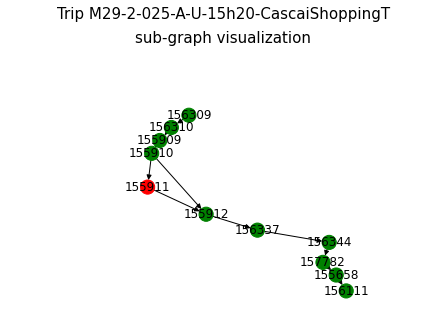

In [100]:
# Graph visualization
color_map = []
for node in G_main.subgraph(stop_ids_in_trip_to_optimize):
    if node in blocked_stops:
        color_map.append('red')
    else: 
        color_map.append('green')      

nx.draw(
    G_main.subgraph(stop_ids_in_trip_to_optimize),
    pos={k: stop_geometries[k] for k in stop_ids_in_trip_to_optimize},
    with_labels=True,
    node_size = 200,
    node_color = color_map
)
ax.legend()
plt.suptitle('sub-graph visualization', size=15)
plt.title(f'Trip {trip_to_optimize}', size=15)
plt.axis('off')
plt.show()

The graph above shows the trip stops to be optimised as nodes. In particular, the red node is the one subject to interruption due to work. The edges represent the possible connections between the stops, not necessarily all of them belong to the trip under observation. For example the edge from 155910 to 155912 is not of this specific trip.
However, in case of a break in stop 155911, one option is to exploit that connection and skip the compromised stop.

#### Shortest path

#####**Case 1:** another valid path already exists


Let's start to solve the problem in the simplest scenario, i.e. the case where there is an alternative path between the stop before and after the one with the interruption.

In [101]:
# Graph removing blocked stops
G_intervention = G_main.copy()
G_intervention.remove_nodes_from(
    blocked_stops
)

In practice

1. the bus travels along the planned path until it reaches the stop before the one having an interruption;

2. the best route to the stop after the one with the interruption is determined via the Dijkstra algorithm. Here the best route is the one minimizing the travelled shape distance;

3. finally, the bus travels from the stops following the one with interruption as planned.

In [102]:
def shortest_path(G, trip_stops, broken_stops):
    to_do_stops = [stop for stop in trip_stops if not (stop in broken_stops)]
    path = []
    for i in range(len(to_do_stops)-1):
        source, target = to_do_stops[i:i+2]
        # If no interruptions
        if G.has_edge(source, target):
            dist = G[source][target]["shape_dist"]
            path.append(
                {"source": source, "target": target, "shape_dist": dist}
            )
            logging.info(f"From {source} to {target} - Distance {dist}")
            continue
        
        # If interruptions and another path exists
        try:
            dijkstra_path = nx.dijkstra_path(
                G, source, target, weight="shape_dist"
            )
            for j in range(len(dijkstra_path)-1):
                dijkstra_source, dijkstra_target = dijkstra_path[j:j+2]
                dijkstra_dist = G[dijkstra_source][dijkstra_target]["shape_dist"]
                path.append(
                    {
                     "source": dijkstra_source,
                     "target": dijkstra_target,
                     "shape_dist": dijkstra_dist
                    }
                )
                logging.info(
                    f"From {dijkstra_source} to {dijkstra_target} - Distance {dijkstra_dist}")
        except:
            logging.warning(f"No path from {source} to {target}")
            path.append(
                {"source": source, "target": target, "shape_dist": np.Inf}
            )
            break
    return path

In [103]:
shortest_path_solution = shortest_path(G_intervention, stop_ids_in_trip_to_optimize, blocked_stops)

2022-04-23 03:51:00,189 | INFO : From 156309 to 156310 - Distance 299.69
2022-04-23 03:51:00,191 | INFO : From 156310 to 155909 - Distance 310.45
2022-04-23 03:51:00,193 | INFO : From 155909 to 155910 - Distance 312.98
2022-04-23 03:51:00,195 | INFO : From 155910 to 155912 - Distance 1536.3499999999995
2022-04-23 03:51:00,197 | INFO : From 155912 to 156337 - Distance 708.3800000000001
2022-04-23 03:51:00,198 | INFO : From 156337 to 156344 - Distance 745.1799999999998
2022-04-23 03:51:00,199 | INFO : From 156344 to 157782 - Distance 478.9100000000003
2022-04-23 03:51:00,200 | INFO : From 157782 to 155658 - Distance 359.6099999999997
2022-04-23 03:51:00,201 | INFO : From 155658 to 156111 - Distance 599.2399999999998


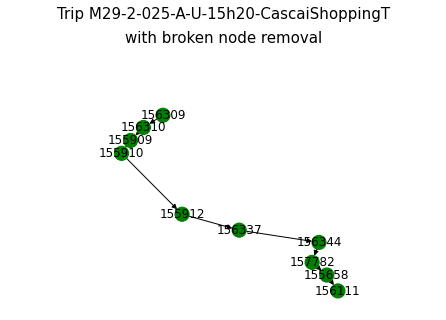

In [104]:
# Graph visualization
color_map = []
for node in G_intervention.subgraph(stop_ids_in_trip_to_optimize):
    if node in blocked_stops:
        color_map.append('red')
    else: 
        color_map.append('green')      

nx.draw(
    G_intervention.subgraph(stop_ids_in_trip_to_optimize),
    pos={k: stop_geometries[k] for k in stop_ids_in_trip_to_optimize},
    with_labels=True,
    node_size = 200,
    node_color = color_map
)
ax.legend()
plt.suptitle('with broken node removal', size=15)
plt.title(f'Trip {trip_to_optimize}', size=15)
plt.axis('off')
plt.show()

**Solution evaluation**

In [105]:
# Original trip shape distance
original_shape_dist = df_edgelist.loc[
    df_edgelist.trip_id == trip_to_optimize
].shape_dist.sum()
print(f"Total shape distance: {original_shape_dist}\n")

# Original number of stops
original_num_stops = df_edgelist.loc[
    df_edgelist.trip_id == trip_to_optimize
].shape[0] +1 
print(f"Number of stops: {original_num_stops}\n")

# Shape distance summary
print("Shape distance summary")
df_edgelist.loc[
    df_edgelist.trip_id == trip_to_optimize
].shape_dist.describe().drop("count")

Total shape distance: 5349.07

Number of stops: 11

Shape distance summary


mean    534.907000
std     204.638132
min     299.690000
25%     324.637500
50%     539.075000
75%     731.412500
max     795.540000
Name: shape_dist, dtype: float64

In [106]:
df_solution_edgelist = pd.DataFrame.from_records(shortest_path_solution)

# Trip shape distance after re-routing
original_shape_dist = df_solution_edgelist.shape_dist.sum()
print(f"Total shape distance: {original_shape_dist}\n")

# Number of stops after re-routing
original_num_stops = df_solution_edgelist.shape[0] + 1 
print(f"Number of stops: {original_num_stops}\n")

# Shape distance summary after re-routing
print("Shape distance summary")
df_solution_edgelist.shape_dist.describe().drop("count")

Total shape distance: 5350.789999999999

Number of stops: 10

Shape distance summary


mean     594.532222
std      393.408536
min      299.690000
25%      312.980000
50%      478.910000
75%      708.380000
max     1536.350000
Name: shape_dist, dtype: float64

The inconvenience caused by the intervention can be quantified as follows.

For passengers:
- the re-routing solution has one less stop ❌
- the maximum distance from one stop to another is increased ❌

For the public transport operator:
- the distance covered is almost the same ✅

##### **Case 2:** adding neighbour nodes connection

The solution proposed above works for this specific case because, despite removing the stop with intervention, another path exists from the stops after and before the intervention. How to solve the problem otherwise? 

The idea is to identify an alternative route that passes through stops as close as possible to the stop with interventions

Let's consider the same trip, but another intervention

In [107]:
# Select a trip
trip_to_optimize = "M29-2-025-A-U-15h20-CascaiShoppingT"

# stop ids of the trip to optimize
stop_ids_in_trip_to_optimize = stops_by_trip.loc[
    stops_by_trip.trip_id==trip_to_optimize].stop_ids.values.tolist()[0]

# stop names of the trip to optimize
stop_names_in_trip_to_optimize = stops_by_trip.loc[
    stops_by_trip.trip_id==trip_to_optimize].stop_names.values.tolist()[0]

In [108]:
# Select one or more stop names where to simulate an intervention
interventions_stop_names = ["Escola de Hotelaria do Estoril"]

# blocked stops
lists_of_blocked_stops = stops_by_trip_and_name.loc[
    (stops_by_trip_and_name.trip_id==trip_to_optimize) &
    (stops_by_trip_and_name.stop_name.isin(interventions_stop_names))
    ].stop_ids.values.tolist()

blocked_stops = [
    stop for stop_list in lists_of_blocked_stops for stop in stop_list
]

blocked_stops

[156337]

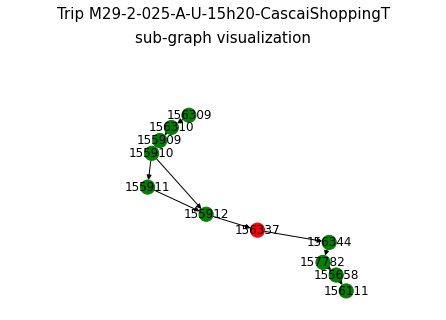

In [109]:
# Graph visualization
color_map = []
for node in G_main.subgraph(stop_ids_in_trip_to_optimize):
    if node in blocked_stops:
        color_map.append('red')
    else: 
        color_map.append('green')      

nx.draw(
    G_main.subgraph(stop_ids_in_trip_to_optimize),
    pos={k: stop_geometries[k] for k in stop_ids_in_trip_to_optimize},
    with_labels=True,
    node_size = 200,
    node_color = color_map
)
ax.legend()
plt.suptitle('sub-graph visualization', size=15)
plt.title(f'Trip {trip_to_optimize}', size=15)
plt.axis('off')
plt.show()

In [110]:
# Graph removing blocked stops
G_intervention = G_main.copy()
G_intervention.remove_nodes_from(
    blocked_stops
)

The previous algorithm does not succeed because a path from stop 155912 to stop 156344 does not exist

In [111]:
shortest_path_solution = shortest_path(G_intervention, stop_ids_in_trip_to_optimize, blocked_stops)

2022-04-23 03:51:00,866 | INFO : From 156309 to 156310 - Distance 299.69
2022-04-23 03:51:00,868 | INFO : From 156310 to 155909 - Distance 310.45
2022-04-23 03:51:00,870 | INFO : From 155909 to 155910 - Distance 312.98
2022-04-23 03:51:00,872 | INFO : From 155910 to 155911 - Distance 795.5400000000001
2022-04-23 03:51:00,874 | INFO : From 155911 to 155912 - Distance 739.0899999999999
2022-04-23 03:51:00,881 | WARNING : No path from 155912 to 156344


We then add new connections to the graph, allowing for the possibility of the bus passing through roads not on the transport map in the event of an intervention.

In order to have more flexibility, we assume that the bus can stop on other trip stops. Let's take the 3 closest to the stop as an example.

In [112]:
def get_stop_name(stop_id):
    stop_name = df_stops.loc[df_stops.stop_id==stop_id].stop_name.values[0]
    return stop_name

In [113]:
# Nearest stops
nearest_stops = [
    k[0] for k in df_sorted_distances_from_stop.loc[
        df_sorted_distances_from_stop.index==blocked_stops[0]
    ].to_stop_dist.values[0]
]

nearest_stops = [
    stop for stop in nearest_stops if not (
        stop in stop_ids_in_trip_to_optimize or
        get_stop_name(stop) in stop_names_in_trip_to_optimize
    )
]

nearests = nearest_stops[:min(3, len(nearest_stops))]
nearests

[5012, 155922, 5936]

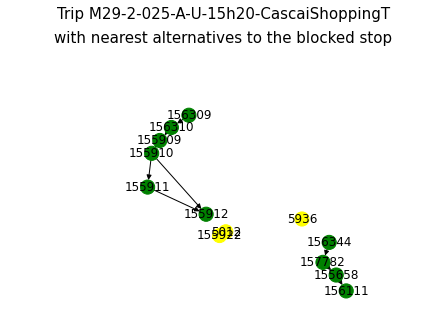

In [114]:
# Graph visualization
color_map = []
for node in G_intervention.subgraph(stop_ids_in_trip_to_optimize+nearests):
    if node in blocked_stops:
        color_map.append('red')
    elif node in nearest_stops[:min(5, len(nearest_stops))]:
        color_map.append('yellow')
    else:
        color_map.append('green')

nx.draw(
    G_intervention.subgraph(nearests+stop_ids_in_trip_to_optimize),
    pos={k: stop_geometries[k] for k in stop_ids_in_trip_to_optimize+nearests},
    with_labels=True,
    node_size = 200,
    node_color = color_map
)
ax.legend()
plt.suptitle('with nearest alternatives to the blocked stop', size=15)
plt.title(f'Trip {trip_to_optimize}', size=15)
plt.axis('off')
plt.show()

We request the shape travelled distance to Google Maps API service

In [ ]:
# User API key
google_api_key = input('Enter your Google API key: ')

In [116]:
gmaps = googlemaps.Client(key=google_api_key)

In [117]:
def get_lat_lon(stop_id):
    lat = df_stops.loc[df_stops.stop_id == stop_id].stop_lat.values[0]
    lon = df_stops.loc[df_stops.stop_id == stop_id].stop_lon.values[0]
    return lat, lon

In [118]:
def new_graph_edges(G, nodes):
    new_edges = []

    for source in nodes:
        for target in nodes:
            logging.info(f"Source {source}\t Target {target}")
            
            # If source = target
            if source==target:
                continue

            # If edge already exists
            if G.has_edge(source, target):
                logging.info(f"Already existing edge")
                continue
            
            source_lat, source_lon = get_lat_lon(source)
            target_lat, target_lon = get_lat_lon(target)

            logging.info(f"Querying Google from {source} to {target}")
            distance_matrix_result = gmaps.distance_matrix(
                origins = [(source_lat, source_lon)],
                destinations = [(target_lat, target_lon)],
                mode="driving", units="metric"
            )
            distance = distance_matrix_result["rows"][0]["elements"][0]["distance"]["value"]
            
            new_edges.append(
               {"source": source, "target": target, "shape_dist": distance}
            )
    
    return new_edges

In [119]:
# Request new shape distances
new_edges = new_graph_edges(G_intervention, [155912]+nearests+[156344])

df_edgelist_with_nearests = pd.concat(
    [df_edgelist, pd.DataFrame.from_records(new_edges)]
)

2022-04-23 03:51:18,234 | INFO : Source 155912	 Target 155912
2022-04-23 03:51:18,236 | INFO : Source 155912	 Target 5012
2022-04-23 03:51:18,245 | INFO : Querying Google from 155912 to 5012
2022-04-23 03:51:18,409 | INFO : Source 155912	 Target 155922
2022-04-23 03:51:18,414 | INFO : Querying Google from 155912 to 155922
2022-04-23 03:51:18,552 | INFO : Source 155912	 Target 5936
2022-04-23 03:51:18,559 | INFO : Querying Google from 155912 to 5936
2022-04-23 03:51:18,642 | INFO : Source 155912	 Target 156344
2022-04-23 03:51:18,647 | INFO : Querying Google from 155912 to 156344
2022-04-23 03:51:18,795 | INFO : Source 5012	 Target 155912
2022-04-23 03:51:18,802 | INFO : Querying Google from 5012 to 155912
2022-04-23 03:51:18,892 | INFO : Source 5012	 Target 5012
2022-04-23 03:51:18,894 | INFO : Source 5012	 Target 155922
2022-04-23 03:51:18,902 | INFO : Querying Google from 5012 to 155922
2022-04-23 03:51:19,005 | INFO : Source 5012	 Target 5936
2022-04-23 03:51:19,014 | INFO : Queryin

In [120]:
# Networkx graph
G_with_nearests = nx.from_pandas_edgelist(
    df = df_edgelist_with_nearests, source = 'source', target = 'target',
    edge_attr = ['shape_dist'], create_using = nx.DiGraph()
)

In [121]:
# Networkx graph without blocked connections
G_with_nearests_intervention = G_with_nearests.copy()
G_with_nearests_intervention.remove_nodes_from(
    blocked_stops
)

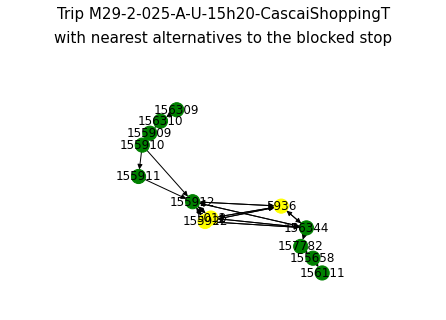

In [122]:
# Graph visualization
color_map = []
for node in G_with_nearests_intervention.subgraph(stop_ids_in_trip_to_optimize+nearests):
    if node in blocked_stops:
        color_map.append('red')
    elif node in nearest_stops[:min(5, len(nearest_stops))]:
        color_map.append('yellow')
    else:
        color_map.append('green')

nx.draw(
    G_with_nearests_intervention.subgraph(nearests+stop_ids_in_trip_to_optimize),
    pos={k: stop_geometries[k] for k in stop_ids_in_trip_to_optimize+nearests},
    with_labels=True,
    node_size = 200,
    node_color = color_map
)
ax.legend()
plt.suptitle('with nearest alternatives to the blocked stop', size=15)
plt.title(f'Trip {trip_to_optimize}', size=15)
plt.axis('off')
plt.show()

In [123]:
# Shortest path solution
shortest_path_solution = shortest_path(
    G_with_nearests_intervention, stop_ids_in_trip_to_optimize, blocked_stops
)

2022-04-23 03:51:20,987 | INFO : From 156309 to 156310 - Distance 299.69
2022-04-23 03:51:20,989 | INFO : From 156310 to 155909 - Distance 310.45
2022-04-23 03:51:20,992 | INFO : From 155909 to 155910 - Distance 312.98
2022-04-23 03:51:20,995 | INFO : From 155910 to 155911 - Distance 795.5400000000001
2022-04-23 03:51:20,997 | INFO : From 155911 to 155912 - Distance 739.0899999999999
2022-04-23 03:51:21,000 | INFO : From 155912 to 156344 - Distance 1453.0
2022-04-23 03:51:21,001 | INFO : From 156344 to 157782 - Distance 478.9100000000003
2022-04-23 03:51:21,003 | INFO : From 157782 to 155658 - Distance 359.6099999999997
2022-04-23 03:51:21,004 | INFO : From 155658 to 156111 - Distance 599.2399999999998


With the addition of the new connections we are able to find a solution!

**Solution evaluation**

In [124]:
# Original trip shape distance
original_shape_dist = df_edgelist.loc[
    df_edgelist.trip_id == trip_to_optimize
].shape_dist.sum()
print(f"Total shape distance: {original_shape_dist}\n")

# Original number of stops
original_num_stops = df_edgelist.loc[
    df_edgelist.trip_id == trip_to_optimize
].shape[0] +1 
print(f"Number of stops: {original_num_stops}\n")

# Shape distance summary
print("Shape distance summary")
df_edgelist.loc[
    df_edgelist.trip_id == trip_to_optimize
].shape_dist.describe().drop("count")

Total shape distance: 5349.07

Number of stops: 11

Shape distance summary


mean    534.907000
std     204.638132
min     299.690000
25%     324.637500
50%     539.075000
75%     731.412500
max     795.540000
Name: shape_dist, dtype: float64

In [125]:
df_solution_edgelist = pd.DataFrame.from_records(shortest_path_solution)

# Trip shape distance after re-routing
original_shape_dist = df_solution_edgelist.shape_dist.sum()
print(f"Total shape distance: {original_shape_dist}\n")

# Number of stops after re-routing
original_num_stops = df_solution_edgelist.shape[0] + 1 
print(f"Number of stops: {original_num_stops}\n")

# Shape distance summary after re-routing
print("Shape distance summary")
df_solution_edgelist.shape_dist.describe().drop("count")

Total shape distance: 5348.51

Number of stops: 10

Shape distance summary


mean     594.278889
std      373.120764
min      299.690000
25%      312.980000
50%      478.910000
75%      739.090000
max     1453.000000
Name: shape_dist, dtype: float64

This solution has the same problems as in case 1 since it prefers to skip the stop instead of rerouting it to neighbouring nodes.

##### **Case 3:** forcing blocked stop rerouting

We can try to see what happens if we force the stop rerouting by not allowing the link from 155912 to 156344

In [126]:
new_edges_wo_particular_cases = [
    edge for edge in new_edges if not
    (edge['source']==155912 and edge['target']==156344) and
    (edge['source']!=156344) and (edge['target']!=155912)
]

In [127]:
# Request new shape distances
df_edgelist_with_nearests = pd.concat(
    [df_edgelist, pd.DataFrame.from_records(new_edges_wo_particular_cases)]
)

In [128]:
# Networkx graph
G_with_nearests = nx.from_pandas_edgelist(
    df = df_edgelist_with_nearests, source = 'source', target = 'target',
    edge_attr = ['shape_dist'], create_using = nx.DiGraph()
)

In [129]:
# Networkx graph without blocked connections
G_with_nearests_intervention = G_with_nearests.copy()
G_with_nearests_intervention.remove_nodes_from(
    blocked_stops
)

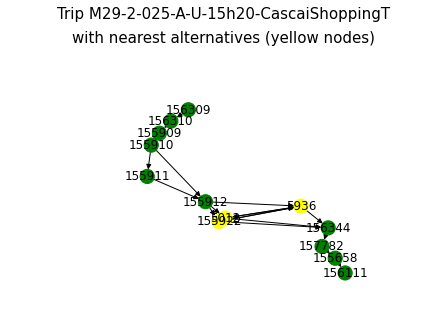

In [130]:
# Graph visualization
color_map = []
for node in G_with_nearests_intervention.subgraph(stop_ids_in_trip_to_optimize+nearests):
    if node in blocked_stops:
        color_map.append('red')
    elif node in nearest_stops[:min(5, len(nearest_stops))]:
        color_map.append('yellow')
    else:
        color_map.append('green')

nx.draw(
    G_with_nearests_intervention.subgraph(nearests+stop_ids_in_trip_to_optimize),
    pos={k: stop_geometries[k] for k in stop_ids_in_trip_to_optimize+nearests},
    with_labels=True,
    node_size = 200,
    node_color = color_map
)
ax.legend()
plt.suptitle('with nearest alternatives (yellow nodes)', size=15)
plt.title(f'Trip {trip_to_optimize}', size=15)
plt.axis('off')
plt.show()

In [131]:
# Shortest path solution
shortest_path_solution = shortest_path(
    G_with_nearests_intervention, stop_ids_in_trip_to_optimize, blocked_stops
)

2022-04-23 03:51:21,919 | INFO : From 156309 to 156310 - Distance 299.69
2022-04-23 03:51:21,922 | INFO : From 156310 to 155909 - Distance 310.45
2022-04-23 03:51:21,924 | INFO : From 155909 to 155910 - Distance 312.98
2022-04-23 03:51:21,926 | INFO : From 155910 to 155911 - Distance 795.5400000000001
2022-04-23 03:51:21,928 | INFO : From 155911 to 155912 - Distance 739.0899999999999
2022-04-23 03:51:21,930 | INFO : From 155912 to 155922 - Distance 502.0
2022-04-23 03:51:21,931 | INFO : From 155922 to 156344 - Distance 1038.0
2022-04-23 03:51:21,933 | INFO : From 156344 to 157782 - Distance 478.9100000000003
2022-04-23 03:51:21,934 | INFO : From 157782 to 155658 - Distance 359.6099999999997
2022-04-23 03:51:21,935 | INFO : From 155658 to 156111 - Distance 599.2399999999998


**Solution evaluation**

In [132]:
# Original trip shape distance
original_shape_dist = df_edgelist.loc[
    df_edgelist.trip_id == trip_to_optimize
].shape_dist.sum()
print(f"Total shape distance: {original_shape_dist}\n")

# Original number of stops
original_num_stops = df_edgelist.loc[
    df_edgelist.trip_id == trip_to_optimize
].shape[0] +1 
print(f"Number of stops: {original_num_stops}\n")

# Shape distance summary
print("Shape distance summary")
df_edgelist.loc[
    df_edgelist.trip_id == trip_to_optimize
].shape_dist.describe().drop("count")

Total shape distance: 5349.07

Number of stops: 11

Shape distance summary


mean    534.907000
std     204.638132
min     299.690000
25%     324.637500
50%     539.075000
75%     731.412500
max     795.540000
Name: shape_dist, dtype: float64

In [133]:
df_solution_edgelist = pd.DataFrame.from_records(shortest_path_solution)

# Trip shape distance after re-routing
original_shape_dist = df_solution_edgelist.shape_dist.sum()
print(f"Total shape distance: {original_shape_dist}\n")

# Number of stops after re-routing
original_num_stops = df_solution_edgelist.shape[0] + 1 
print(f"Number of stops: {original_num_stops}\n")

# Shape distance summary after re-routing
print("Shape distance summary")
df_solution_edgelist.shape_dist.describe().drop("count")

Total shape distance: 5435.509999999999

Number of stops: 11

Shape distance summary


mean     543.551000
std      248.556169
min      299.690000
25%      324.637500
50%      490.455000
75%      704.127500
max     1038.000000
Name: shape_dist, dtype: float64

Forcing the broken stop rerouting

- the total shape distance increases (5435.5 VS 5348.5) ❌
- the maximum distance between stops decreases (1038 VS 1453) ✅



##### **Case 4**: multiple interventions

In [134]:
# Select one or more stop names where to simulate an intervention
interventions_stop_names = ["Av. República - Ponte", "Escola de Hotelaria do Estoril"]

# blocked stops
lists_of_blocked_stops = stops_by_trip_and_name.loc[
    (stops_by_trip_and_name.trip_id==trip_to_optimize) &
    (stops_by_trip_and_name.stop_name.isin(interventions_stop_names))
    ].stop_ids.values.tolist()

blocked_stops = [
    stop for stop_list in lists_of_blocked_stops for stop in stop_list
]

blocked_stops

[155911, 156337]

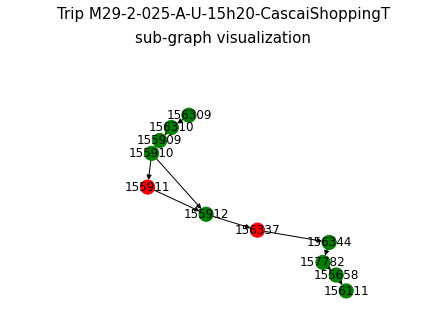

In [135]:
# Graph visualization
color_map = []
for node in G_main.subgraph(stop_ids_in_trip_to_optimize):
    if node in blocked_stops:
        color_map.append('red')
    else: 
        color_map.append('green')      

nx.draw(
    G_main.subgraph(stop_ids_in_trip_to_optimize),
    pos={k: stop_geometries[k] for k in stop_ids_in_trip_to_optimize},
    with_labels=True,
    node_size = 200,
    node_color = color_map
)
ax.legend()
plt.suptitle('sub-graph visualization', size=15)
plt.title(f'Trip {trip_to_optimize}', size=15)
plt.axis('off')
plt.show()

In [136]:
# Networkx graph
G_with_nearests = nx.from_pandas_edgelist(
    df = df_edgelist_with_nearests, source = 'source', target = 'target',
    edge_attr = ['shape_dist'], create_using = nx.DiGraph()
)

In [137]:
# Networkx graph without blocked connections
G_with_nearests_intervention = G_with_nearests.copy()
G_with_nearests_intervention.remove_nodes_from(
    blocked_stops
)

In [138]:
# Shortest path solution
shortest_path_solution = shortest_path(
    G_with_nearests_intervention, stop_ids_in_trip_to_optimize, blocked_stops
)

2022-04-23 03:51:22,764 | INFO : From 156309 to 156310 - Distance 299.69
2022-04-23 03:51:22,766 | INFO : From 156310 to 155909 - Distance 310.45
2022-04-23 03:51:22,767 | INFO : From 155909 to 155910 - Distance 312.98
2022-04-23 03:51:22,771 | INFO : From 155910 to 155912 - Distance 1536.3499999999995
2022-04-23 03:51:22,774 | INFO : From 155912 to 155922 - Distance 502.0
2022-04-23 03:51:22,777 | INFO : From 155922 to 156344 - Distance 1038.0
2022-04-23 03:51:22,779 | INFO : From 156344 to 157782 - Distance 478.9100000000003
2022-04-23 03:51:22,782 | INFO : From 157782 to 155658 - Distance 359.6099999999997
2022-04-23 03:51:22,784 | INFO : From 155658 to 156111 - Distance 599.2399999999998


In [139]:
G_solution = nx.from_pandas_edgelist(
    df = pd.DataFrame.from_records(shortest_path_solution),
    source = 'source', target = 'target',
    edge_attr = ['shape_dist'], create_using = nx.DiGraph()
)

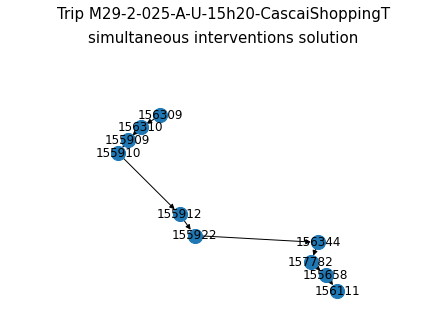

In [140]:
nx.draw(
    G_solution,
    pos={k: stop_geometries[k] for k in G_solution.nodes()},
    with_labels=True,
    node_size = 200
)
ax.legend()
plt.suptitle('simultaneous interventions solution', size=15)
plt.title(f'Trip {trip_to_optimize}', size=15)
plt.axis('off')
plt.show()

### Conclusions and improvements

Even if this proposed solution is very simple, we can say that the initial results are promising. In addition, our approach ensures fast computation, since nodes remain only locally connected, and multiple interventions robustness. Finally, this method could be easily generalized to other urban scenarios adding constraints and payoffs.

In the solution proposed here we have aimed to minimise the distance travelled by the bus.

However, the problem can easily be reformulated by changing the objective function.

As alternatives we have considered
1. minimise the cumulative delay at the stops following the interruptions

2. minimise the distance between the stop before the interruption and the next one, in order not to create difficulties for passengers to reach the stops

3. minimise, by weighting demand, the absence of service at a stop. For example, stops in the proximity of schools and/or hospitals should always be served and, if not accessible, replaced with a stop as close as possible to the one under interruption or to the service.

In this regard, the code for obtaining the geolocation of schools and hospitals can be found at the end of the appendix.

Furthermore, one of the possible improvements for the model is to simultaneously optimise the trips of buses travelling at the same times on different routes.

For example, if the buses have stops in common, the bus less disadvantaged by the intervention could compensate for the deficiencies of the bus more disadvantaged.

## 👓 References




### Dataset sources

*   [GTFS Public Transport Network of Cascais](https://dadosabertos.cascais.pt/dataset/gtfs-mobicascais)
*   [Bus Routes](https://dadosabertos.cascais.pt/dataset/carreira-de-autocarro)
*   [Road Network](https://dadosabertos.cascais.pt/dataset/eixo-de-via)
*   [Interventions in public roads](https://dadosabertos.cascais.pt/dataset/obras-de-intervencao-na-via-publica)
*   [Cascais data dictionary](https://docs.google.com/spreadsheets/d/10IUS4sdJPEgGHunAlUyG50ww2Kntt69MFSnePL5h-BU/edit#gid=850019181)

## ⏭️ Appendix


### GTFS Public Transport of Cascais

Further available data

##### Agency

Transit agencies with service represented in this dataset.

[agency field definitions](https://developers.google.com/transit/gtfs/reference/#agencytxt)

The available data is from only one transport agency: [Cascais Próxima E.M. S.A.](http://www.mobicascais.pt/)

In [141]:
# Agency
df_agency = pd.read_csv(os.path.join(gtfs_dataPath, "agency.txt"))
df_agency

,agency_id,agency_name,agency_url,agency_timezone,agency_lang,agency_phone,agency_fare_url
0,mobi_cascais_bus,Cascais Próxima E.M. S.A.,http://www.mobicascais.pt/,Europe/Lisbon,pt,800203186,https://www.mobicascais.pt/


##### Calendar

Service dates specified using a weekly schedule with start and end dates.

[Calendar field descriptions](https://developers.google.com/transit/gtfs/reference/#calendartxt)

In [142]:
# Calendar
df_calendar = pd.read_csv(os.path.join(gtfs_dataPath, "calendar.txt"))

# Convert "start_date" and "end_date" to datetime
df_calendar.loc[:, "start_date"] = pd.to_datetime(
    df_calendar.loc[:, "start_date"], format="%Y%m%d"
)
df_calendar.loc[:, "end_date"] = pd.to_datetime(
    df_calendar.loc[:, "end_date"], format="%Y%m%d"
)

df_calendar

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,A-DF,0,0,0,0,0,0,1,2022-01-02,2022-12-31
1,A-S,0,0,0,0,0,1,0,2022-01-02,2022-12-31
2,A-SDF,0,0,0,0,0,1,1,2022-01-02,2022-12-31
3,A-U,1,1,1,1,1,0,0,2022-01-02,2022-12-31
4,E-U,1,1,1,1,1,0,0,2022-01-02,2022-12-31
5,FE-U,1,1,1,1,1,0,0,2022-01-02,2022-12-31


The week services offer 2048 trips per day, while during weekend days the available trips are almost halved: 1183 on Saturday, 1060 on Sunday:

In [143]:
df_stop_times_stops_trips.groupby(["service_id"]).trip_id.nunique()

service_id
A-DF      413
A-S       536
A-SDF     647
A-U      2039
E-U         5
FE-U        4
Name: trip_id, dtype: int64

##### Calendar dates

Exceptions for the services defined in the calendar.txt

[Calendar dates field descriptions](https://developers.google.com/transit/gtfs/reference/#calendar_datestxt)

In [144]:
# Calendar dates
df_calendar_dates = pd.read_csv(
    os.path.join(gtfs_dataPath, "calendar_dates.txt")
)

# Convert "date" to datetime
df_calendar_dates.loc[:, "date"] = pd.to_datetime(
    df_calendar_dates.loc[:, "date"], format="%Y%m%d"
)

df_calendar_dates

,service_id,date,exception_type
0,A-DF,2022-04-15,1
1,A-DF,2022-08-15,1
2,A-DF,2022-06-13,1
3,A-DF,2022-06-10,1
4,A-DF,2022-04-25,1
...,...,...,...
295,FE-U,2022-03-03,2
296,FE-U,2022-11-03,2
297,FE-U,2022-03-02,2
298,FE-U,2022-11-02,2


**Note on exception type:**

Indicates whether service is available on the date specified in the date field. Valid options are:

1 - Service has been added for the specified date.

2 - Service has been removed for the specified date.

Here we see that weekend services are added, while weekly services are removed when an exception occurs:

In [145]:
# Number of exceptions per service ID and type of the exception
df_calendar_dates.groupby(
    ["service_id", "exception_type"]
).size().to_frame('num_exceptions')

,,num_exceptions
service_id,exception_type,
A-DF,1,10
A-SDF,1,10
A-U,2,10
E-U,2,81
FE-U,2,189


Playing with the following time series plot, we notice that the 10 exceptions for the A-DF, A-SDF, A-U service are occurring on the same date. On the other hand, the exceptions for the E-U and the FE-U services are kind of complementary:

In [ ]:
# Time series dataframe
ts_calendar_dates = df_calendar_dates.sort_values('date')
ts_calendar_dates.index = ts_calendar_dates['date']
ts_calendar_dates.drop('date', axis=1, inplace=True)

# Choose resample
resample_freq = 'D' # D, M, Y

fig = px.line(
    ts_calendar_dates.groupby(
        'service_id'
    ).resample(resample_freq)['exception_type'].count().reset_index(),
    x='date', y="exception_type", color='service_id',
    labels={"service_id": "service id", "date": "date",
            "exception_type": "n. of exceptions"},
    title=f"Time series of n. of exception per service id"
)

fig.show()

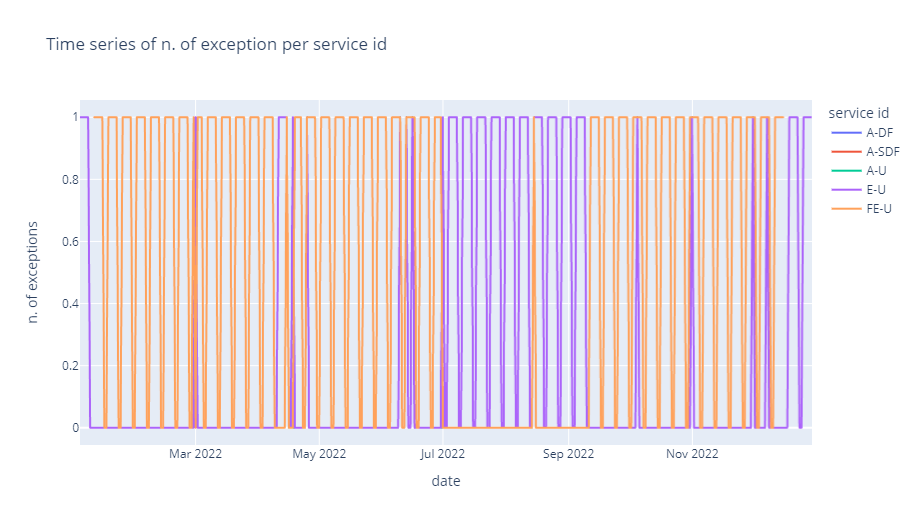

##### Fare attributes

Fare information for a transit agency's routes.

[Fare attributes field descriptions](https://developers.google.com/transit/gtfs/reference/#fare_attributestxt)

In [147]:
# Fare attributes
df_fare_attributes = pd.read_csv(
    os.path.join(gtfs_dataPath, "fare_attributes.txt")
)
df_fare_attributes

,fare_id,price,currency_type,payment_method,transfers,agency_id,transfer_duration
0,Bilhete diário eletrónico,1.5,EUR,1,NaN,mobi_cascais_bus,NaN
1,Bilhete diário de bordo,2.0,EUR,0,NaN,mobi_cascais_bus,NaN


##### Feed info

Dataset metadata, including publisher, version, and expiration information.	

[Feed info field descriptions](https://developers.google.com/transit/gtfs/reference/#feed_infotxt)

In [148]:
# Feed info
df_feed_info = pd.read_csv(os.path.join(gtfs_dataPath, "feed_info.txt"))

# Convert "feed_start_date" and "feed_end_date" to datetime
df_feed_info.loc[:, "feed_start_date"] = pd.to_datetime(
    df_feed_info.loc[:, "feed_start_date"], format="%Y%m%d"
)
df_feed_info.loc[:, "feed_end_date"] = pd.to_datetime(
    df_feed_info.loc[:, "feed_end_date"], format="%Y%m%d"
)

df_feed_info

,feed_publisher_name,feed_publisher_url,feed_lang,feed_start_date,feed_end_date,feed_version
0,Cascais Próxima,https://www.mobicascais.pt/,pt,2022-04-08,2022-12-31,20220406


### Bus routes

Further vosual insights

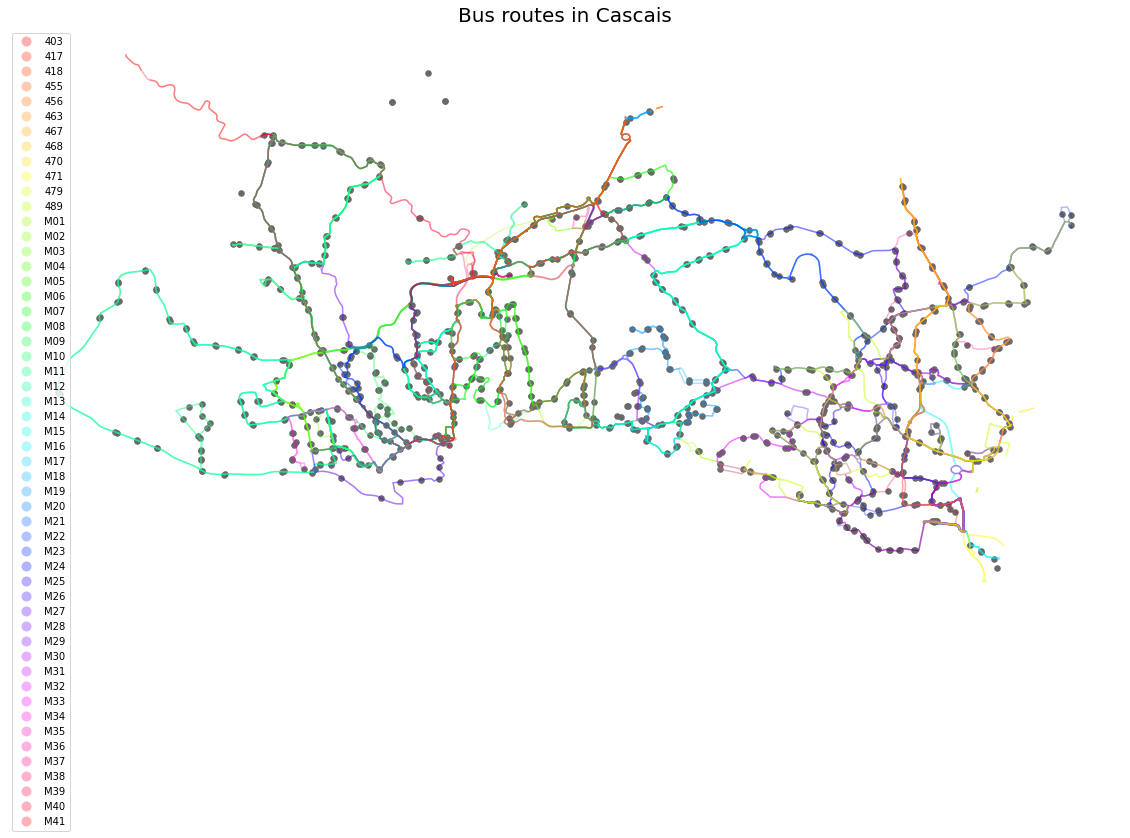

In [149]:
fig, ax = plt.subplots(figsize = (20,15))


# Bus routes data
geo_bus_routes.plot(
    ax=ax, column='route_id', cmap ='hsv', alpha= 0.3, legend=True
)

# stops Internventions coordinates
geo_stops.plot(
    ax=ax, color='dimgray', markersize=30,  legend = True, label = 'bus'
)


plt.title('Bus routes in Cascais', size=20)
plt.axis('off')
plt.show()

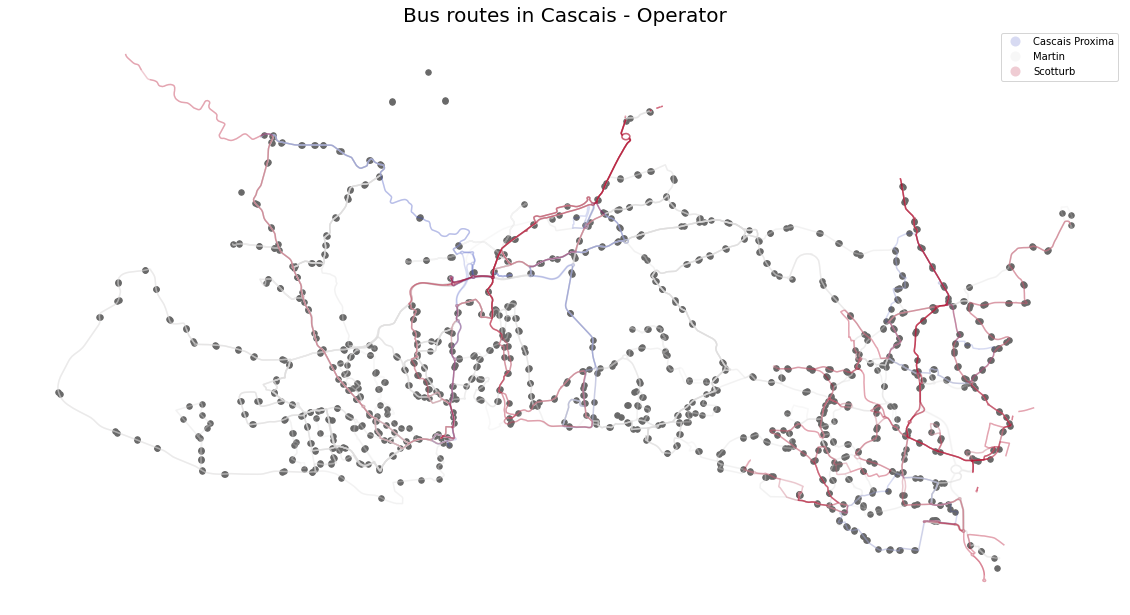

In [150]:
fig, ax = plt.subplots(figsize = (20,15))


# Bus routes data
geo_bus_routes.plot(
    ax=ax, column='operator', cmap ='coolwarm', alpha= 0.2, legend=True
)

# stops Internventions coordinates
geo_stops.plot(
    ax=ax, color='dimgray', markersize=30,  legend = True, label = 'bus'
)


plt.title('Bus routes in Cascais - Operator', size=20)
plt.axis('off')
plt.show()

### Road Network

[source](https://dadosabertos.cascais.pt/dataset/eixo-de-via)

#### Data request



```
!wget https://dadosabertos.cascais.pt/pt_PT/dataset/eb75cecf-f967-4849-a575-234ab2472e9f/resource/1e3ed047-70ec-4d1b-9b25-56ea528adb12/download/eixodevia.csv \
    -O data/road_network.csv \
    --no-check-certificate
```



#### Data description

[Description source](https://docs.google.com/spreadsheets/d/10IUS4sdJPEgGHunAlUyG50ww2Kntt69MFSnePL5h-BU/edit#gid=850019181)

"List of longitudinal lines that divide a traffic lane into one or more traffic directions. Can be used to map street names to street ID. One street can be divided up into several tracks."

#### EDA

In [151]:
# Road network
df_road_network = pd.read_csv(
    os.path.join(dataPath, "road_network.csv"),
    encoding = "ISO-8859-1", sep=","
)

# Rename columns
df_road_network.rename(
    columns = {
        'Id':'id',
        'Nome':'name',
        'Tipo': 'type',
        'Classificação': 'classification',
        'Comprimento': 'length',
        'Sentido': 'direction',
        'Código': 'code',
        'Rua Id': 'street_id'
    },
    inplace = True
)

# Show dataset info
df_road_network.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12015 entries, 0 to 12014
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              12015 non-null  int64  
 1   name            12013 non-null  object 
 2   type            12015 non-null  object 
 3   classification  12015 non-null  object 
 4   length          12015 non-null  float64
 5   direction       11611 non-null  object 
 6   code            11162 non-null  float64
 7   street_id       12013 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 751.1+ KB


In [152]:
# Dataset view
df_road_network.head(5)

,id,name,type,classification,length,direction,code,street_id
0,2116963,Rua Lucília do Carmo (Fadista),Normal,Rua,44.810,Dois Sentidos,20000.0,1686247.0
1,2116991,Rua Baptista Pereira,Normal,Rua,16.330,Dois Sentidos,20002.0,1675638.0
2,2116999,Rua Baptista Pereira,Normal,Rua,15.540,Directo,20003.0,1675638.0
3,2234181,Rua Aires de Saldanha,Normal,Rua,8.411,Dois Sentidos,16904.0,2234168.0
4,2234211,Praceta Aires de Saldanha,Normal,Rua,38.820,Dois Sentidos,16905.0,2234217.0


In [153]:
# Number of unique values per column
df_road_network.nunique(dropna=False)

id                12015
name               3491
type                  3
classification        3
length             7330
direction             5
code               7718
street_id          4506
dtype: int64

In [154]:
# Combinations of type, classification and direction
df_road_network.groupby(
    ["type", "classification", "direction"]
).size()

type               classification       direction    
Normal             Acesso a via rápida  Directo            33
                                        Inverso             9
                   Desconhecido         Pedonal             1
                   Rua                  Directo          1173
                                        Dois Sentidos    8226
                                        Inverso          2010
                                        Pedonal            82
Passagem inferior  Acesso a via rápida  Directo             3
                                        Inverso             1
                   Rua                  Directo            16
                                        Dois Sentidos      11
                                        Inverso            11
                                        Pedonal            14
Passagem superior  Acesso a via rápida  Directo             1
                   Rua                  Directo             3
                

### Points of Interests

#### Hospitals

In [157]:
# Get Hospital geolocations from open street map
tags = {'amenity': 'hospital'}
hospitals = ox.geometries_from_place("Cascais, Portugal", tags=tags)

In [158]:
hospitals_points = hospitals[hospitals.geom_type == 'Point']

In [159]:
m = folium.Map([38.70635, -9.41113], zoom_start=20)
locs = zip(hospitals_points.geometry.y, hospitals_points.geometry.x)
for location in locs:
    folium.CircleMarker(location=location).add_to(m)
    m.save(os.path.join(dataPath, 'hospitals.html'))

#### Schools

In [161]:
tags = {'amenity': 'school'}
schools = ox.geometries_from_place("Cascais, Portugal", tags=tags)

In [162]:
schools_points = schools[schools.geom_type == 'Point']

In [ ]:
m = folium.Map([38.70635, -9.41113], zoom_start=20)
locs = zip(schools_points.geometry.y, schools_points.geometry.x)
for location in locs:
    folium.CircleMarker(location=location).add_to(m)
    m.save(os.path.join(dataPath, 'schools.html'))